# Warp factory for Python

This code reflects my effort to reproduce the results and methodology presented in arXiv:2404.03095, albeit with some modifications. During the process, I identified numerous errors in both their paper and the accompanying code, as well as discrepancies between the two, particularly in the explanations of their examples. Consequently, I chose not to rely heavily on their work to validate my results.

In contrast to their approach, I aim to fully utilize the symbolic capabilities of SymPy and EinsteinPy to derive analytical expressions for the Einstein and Energy-momentum tensors. By minimizing dependence on numerical approximations, this method provides greater precision and flexibility in theoretical analyses at the cost of time. Therefore no numerical approximation are required to obtain the results. 

### Disclaimer

I would like to report a few errors regarding arXiv:2404.03095 and my work:

- The Alcubierre function is incorrect; they used 
tanh(r+R)-tanh(r-R). Since this function is central to many parts of their paper, it raises concerns that much of their work may be flawed.

- They utilized the Schwarzschild solution as a benchmark, but this solution is highly singular and symmetrcial and seems inappropriate to check their numerical approximation.

- Some of the functions defined in their paper do not correspond to those used in their code, leading to inconsistencies.

- The sampling of the observers' 4-velocities may require reevaluation, particularly in limit cases such as 0s and 1s (both in my code and theirs).

- This version of the code relies heavily on EinsteinPy. If there are errors in that library, I am unable to address them.

- There is a file that tests the tetrahed that is used for arbitrary metrics, so no errors arise from that aspect (both in my code and theirs).

- For a few figures, I provide additional insights into the differences between my results and theirs.

- I cannot guarantee the accuracy of the DEC I developed; I would not be surprised if it contains errors, although the rest of my work seems quite solid, to be honest.

- Additionally, my work may be limited to Cartesian coordinates, which could further restrict its applicability.

### import relevant library

In [1]:
import sympy as sp
import numpy as np

from einsteinpy.symbolic import MetricTensor, ChristoffelSymbols, RiemannCurvatureTensor, RicciTensor, RicciScalar, EinsteinTensor

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

## Operating System

### Functions

In [2]:
def christoffel_x_vector(V,metric_einsteinpy,sp_symbols, vector_is_covariant):
    """
    Computes the product of a Christoffel symbol and a vector field in a given coordinate system.

    Parameters:
    -----------
    V : list or sympy.Array
        The vector field. If `vector_is_covariant` is True, this is assumed to be a covariant vector (with lower indices).
        Otherwise, it is assumed to be a contravariant vector (with upper indices).
    
    metric_einsteinpy : einsteinpy.symbolic.MetricTensor
        The metric tensor object from the EinsteinPy library, representing the spacetime geometry.
        This object is used to compute the Christoffel symbols.
    
    sp_symbols : list of sympy.Symbol
        The list of spacetime coordinate symbols (e.g., [t, x, y, z]) corresponding to the dimension of the system.

    vector_is_covariant : bool
        A flag indicating whether the given vector `V` is covariant (True) or contravariant (False).

    Returns:
    --------
    sympy.Matrix
        - If `vector_is_covariant` is True, returns a matrix A_{uv} where A_{uv} = Γ_{uv}^h * V_h.
        - If `vector_is_covariant` is False, returns a matrix B_u^v where B_u^v = Γ_{uh}^v * V^h.
    
    Description:
    ------------
    This function calculates the matrix product of the Christoffel symbols (Γ_{uv}^h or Γ_{uh}^v) and a vector field `V` 
    in the context of general relativity or differential geometry. The Christoffel symbols, representing the connection 
    coefficients, are computed from the given metric tensor using the EinsteinPy library. Depending on whether the vector 
    `V` is covariant or contravariant, the function returns a matrix describing the corresponding transformation.
    """


    dim=len(sp_symbols)

    # Compute Christoffel Symbols for the given metric
    ch_sym = ChristoffelSymbols.from_metric(metric_einsteinpy)
    
    # Christoffel symbol array (with lower indices)
    T_uv_h = ch_sym.tensor()



    if vector_is_covariant:
        # Initialize matrices A and B
        A_uv = sp.zeros(dim, dim)  # A_{uv} matrix (4x4)
        
        # Perform the matrix multiplication for A_uv = T_{uv}^h * V_h
        for u in range(dim):
            for v in range(dim):
                A_uv[u, v] = sum(T_uv_h[h,u,v] * V[h] for h in range(dim)) #first index is the upper index for christoffel symbol


        return A_uv
        
    else:
        # Initialize matrices A and B
        B_u_v = sp.zeros(dim, dim)  # B_u^v matrix (4x4)
        
        
        # Perform the matrix multiplication for B_u^v = T_{uh}^v * V^h
        for u in range(dim):
            for v in range(dim):
                B_u_v[u, v] = sum(T_uv_h[v,u,h]  * V[h] for h in range(dim))

        return B_u_v




In [3]:
def covariant_derivative(V,metric_einsteinpy,sp_symbols, vector_is_covariant):
    """
    Computes the covariant derivative of a vector field in a given coordinate system, considering the spacetime geometry.

    Parameters:
    -----------
    V : list or sympy.Array
        The vector field. If `vector_is_covariant` is True, this is assumed to be a covariant vector (with lower indices).
        Otherwise, it is assumed to be a contravariant vector (with upper indices).
    
    metric_einsteinpy : einsteinpy.symbolic.MetricTensor
        The metric tensor object from the EinsteinPy library, representing the spacetime geometry.
        This object is used to compute the Christoffel symbols necessary for the covariant derivative.
    
    sp_symbols : list of sympy.Symbol
        The list of spacetime coordinate symbols (e.g., [t, x, y, z]) corresponding to the dimension of the system.

    vector_is_covariant : bool
        A flag indicating whether the given vector `V` is covariant (True) or contravariant (False).

    Returns:
    --------
    sympy.Matrix
        The covariant derivative of the vector `V`, expressed as a matrix of partial derivatives adjusted by 
        the Christoffel symbols. The result is:
        - If `vector_is_covariant` is True, the covariant derivative is given by ∂_i V_j - Γ_{ij}^h * V_h.
        - If `vector_is_covariant` is False, the covariant derivative is given by ∂_i V^j + Γ_{ih}^j * V^h.

    Description:
    ------------
    This function calculates the covariant derivative of a vector field `V` in the context of general relativity 
    or differential geometry. The covariant derivative accounts for the curvature of spacetime (or the manifold) 
    and is computed by combining the partial derivatives of the vector components with the Christoffel symbols 
    derived from the metric tensor. Depending on whether the vector is covariant or contravariant, the function 
    adds or subtracts the Christoffel term to yield the appropriate derivative.
    """

    dim=len(sp_symbols)

    #Initialize an empty matrix for partial derivatives
    partial_matrix = sp.Matrix.zeros(dim,dim)
    
    #Compute the partial derivatives for all combinations
    for i in range(dim):  # iterate over coordinates u^i
        for j in range(dim):  # iterate over vector components V^v
            partial_matrix[i, j] = sp.diff(V[j], sp_symbols[i])
    

    
    ch_V=christoffel_x_vector(V,metric_einsteinpy,sp_symbols, vector_is_covariant)


    if vector_is_covariant:

        return partial_matrix-ch_V

    else:

        return partial_matrix+ch_V


    
    

In [4]:
def get_tetrahed(user_input_metric):
    
    #The tetrahed is defined as in https://arxiv.org/abs/2404.03095 
    #(there is actually a mistake in the paper but not their code, the version here is correct)

    """
    Constructs a tetrad (orthonormal basis) for a given metric based on the formalism outlined in the referenced paper 
    (https://arxiv.org/abs/2404.03095).

    Parameters:
    -----------
    user_input_metric : dict
        A dictionary that substitutes the metric components (g1, g2, ..., g10) with actual values for the spacetime 
        under consideration. This substitution allows for the computation of the tetrad in the specific geometry.

    Returns:
    --------
    tuple (E_0, E_1, E_2, E_3, E_solution)
        - E_0 : sympy.Matrix
            The first vector of the tetrad, representing a time-like or null direction.
        - E_1 : sympy.Matrix
            The second vector of the tetrad, representing a space-like direction.
        - E_2 : sympy.Matrix
            The third vector of the tetrad, representing another space-like direction.
        - E_3 : sympy.Matrix
            The fourth vector of the tetrad, representing the final space-like direction.
        - E_solution : sympy.Matrix
            The complete tetrad matrix, formed by horizontally stacking the vectors E_0, E_1, E_2, and E_3.

    Description:
    ------------
    This function computes a tetrad (orthonormal basis) from the given spacetime metric tensor components.

    The function calculates four basis vectors (E_0, E_1, E_2, E_3), which together form the complete tetrad. The scalars 
    A, B, C, and D are defined based on the metric tensor components and are used to construct the tetrad vectors. 

    The function simplifies each of the computed tetrad vectors using the user-provided metric components and returns 
    both the individual vectors and the combined tetrad matrix for further use.
    """


    
    g = sp.symbols('g1:11')
 
    # Define the scalars A, B, C, and D
    # Define the scalars with adjusted indices
    A = g[9]
    
    B = -g[8]**2 + g[7] * g[9]
    
    C = (-g[4] * g[8]**2 - g[7] * g[6]**2 - g[9] * g[5]**2
         + 2 * g[5] * g[6] * g[8] + g[4] * g[7] * g[9])
    
    
    D = (g[1]**2 * g[8]**2 + g[2]**2 * g[6]**2 + g[3]**2 * g[5]**2
         - g[7] * g[9] * g[1]**2 - g[4] * g[9] * g[2]**2 - g[4] * g[7] * g[3]**2
         - g[0] * g[9] * g[5]**2 - g[0] * g[7] * g[6]**2 - g[0] * g[4] * g[8]**2
         + 2 * g[9] * g[1] * g[2] * g[5] + 2 * g[7] * g[1] * g[3] * g[6]
         + 2 * g[4] * g[2] * g[3] * g[8] + 2 * g[0] * g[5] * g[6] * g[8] 
         - 2 * g[1] * g[2] * g[6] * g[8] - 2 * g[1] * g[3] * g[5] * g[8]
         - 2 * g[2] * g[3] * g[5] * g[6] + g[0] * g[4] * g[7] * g[9])
    
    
    #note : (A,B,C,D) = (-,+,+,+)
    
    E_0 =(1 / sp.sqrt(-C * D)) * sp.Matrix([
        C,   #here, first error of the paper, it's a +C not -C             
         
         g[1] * g[8]**2 + g[2] * g[5] * g[9] + g[3] * g[6] * g[7] - g[1] * g[7] * g[9] - g[2] * g[6] * g[8] - g[3] * g[5] * g[8],
    
        g[2] * g[6]**2 + g[1] * g[5] * g[9] + g[3] * g[4] * g[8] - g[1] * g[6] * g[8] - g[2] * g[4] * g[9] - g[3] * g[5] * g[6],
    
        g[3] * g[5]**2 + g[1] * g[6] * g[7] + g[2] * g[4] * g[8] - g[1] * g[5] * g[8] - g[2] * g[5] * g[6] - g[3] * g[4] * g[7]
    
    ])
    
    E_1=(1 / sp.sqrt(B*C)) * sp.Matrix([
        0,                
         
        B,
    
        #g[5] * g[9] - g[6] * g[8], second error in the paper
        -g[5] * g[9] + g[6] * g[8],
    
        g[5] * g[8] - g[6] * g[7]
    
    ])
    
    E_2=(1 / sp.sqrt(A*B)) * sp.Matrix([
        0,                
         
        0,
    
        A,
    
        -g[8] 
    
    ])
    
    E_3=(1 / sp.sqrt(A)) * sp.Matrix([
        0,                
         
        0,
    
        0,
    
        1
    
    ])
    
    E_solution=matrix = sp.Matrix.hstack(E_0, E_1, E_2, E_3)
    
    
    
    E_0=sp.simplify(E_0.subs(user_input_metric))
    E_1=sp.simplify(E_1.subs(user_input_metric))
    E_2=sp.simplify(E_2.subs(user_input_metric))
    E_3=sp.simplify(E_3.subs(user_input_metric))
    
    E_solution=sp.simplify(E_solution.subs(user_input_metric))

    return E_0, E_1, E_2, E_3, E_solution
        

### Class

In [5]:
class Warp_drive:
    def __init__(self, sp_symbols, function_substitutions, metric_from_user_input):
        """
        Initializes a new Warp_drive object.
        
        :sp_symbols: List of symbols to represent spacetime coordinate.
        
        :function_substitutions. Dictionnary of sympy functions
            example: {f:f_actual,v:v_actual}
            f and v are the symbolic function depending on spacetime coordinates and f_actual 
            and v_actual are the actual functions expression.
            
        :metric_from_user_input: Dictionnary associating g1,g2,...,g9 the symbol of the metric 
        to the desired metric.
        
        """
        g = sp.symbols('g1:11')
        
        metric_from_user_input_ = {
            g[0]: metric_from_user_input["g1"],
            g[1]: metric_from_user_input["g2"],
            g[2]: metric_from_user_input["g3"],
            g[3]: metric_from_user_input["g4"],
            g[4]: metric_from_user_input["g5"],
            g[5]: metric_from_user_input["g6"],
            g[6]: metric_from_user_input["g7"],
            g[7]: metric_from_user_input["g8"],
            g[8]: metric_from_user_input["g9"],
            g[9]: metric_from_user_input["g10"]   
        }


        
        self.symbols = sp_symbols
        self.f_subs = function_substitutions
        self.user_input_metric = metric_from_user_input_

        self.Is_built=False
        
        #define physical quantities
        gravity_const=6.6743*1e-11
        c_speed_const=299792458
        pi_8=8*np.pi

        self.physical_energy_conversion=c_speed_const**4/pi_8/gravity_const
        self.physical_momentum_conversion=self.physical_energy_conversion/c_speed_const



    def build_and_compute(self):
       
    
        #Construct the template on which we are going to substitute user inputs
        g = sp.symbols('g1:11')
        metric_template = sp.Matrix([
            [g[0], g[1], g[2], g[3]],
            [g[1], g[4], g[5], g[6]],
            [g[2], g[5], g[7], g[8]],
            [g[3], g[6], g[8], g[9]]
        ])
    
        
    
        # Update the template
        Metric = metric_template.subs(self.user_input_metric)
        
        # Create a MetricTensor object that can be used with einsteinpy
        m_obj = MetricTensor(sp.Array(Metric), self.symbols)
    
        #no need to compute the following quantity but they are available at this point
        
        # Compute Christoffel symbols
        #ch = ChristoffelSymbols.from_metric(m_obj)
        
        # Compute Riemann Curvature Tensor
        #riemann = RiemannCurvatureTensor.from_christoffels(ch)
        
        # Compute Ricci Tensor
        #ricci = RicciTensor.from_riemann(riemann)
        
        # Compute Ricci Scalar
        #ricci_scalar = RicciScalar.from_riccitensor(ricci)
        
        # Compute EinsteinTensor
        einst = EinsteinTensor.from_metric(m_obj)
        #we go back to sympy object
        Einstein_tensor=einst.tensor() 
        Tuv=sp.simplify(sp.Matrix(Einstein_tensor)) #mind that the unit are not yet correct
    
        self.Metric=Metric
        self.Tuv=Tuv
    
        print("Einstein tensor computed.")#############################################################################
    
    
        #Get tetrahed
        E_0, E_1, E_2, E_3, E_solution = get_tetrahed(self.user_input_metric)
    
        # The tetrahed corresponding to the local observer whose 4-velocity vector is orthogonal 
        # to constant time hypersurface. 

        #display(E_solution)
    
        print("Tetrahed computed.")####################################################################################
        
        #compute Tu^v^, the energy-momentum tensor from the perspective of a local observer 
        Tuv_ref=sp.simplify((E_solution.T)*Tuv*E_solution)
        #Tuv_ref=sp.simplify(E_solution*Tuv*(E_solution.T))
    
        self.Tuv_ref=Tuv_ref

       
        #Momentum ===============================================================
        momentum=Tuv_ref[1:,0]
        
        self.Momentum=momentum
        
        #Metric scalar ==========================================================
    
        #4-velocity vector
        Uu=E_0
        
        U_u=Metric*Uu
        
        Metric_inv=Metric.inv()
        
        P_uv = Metric + U_u*U_u.T
    
        Du_Uv=covariant_derivative(U_u,m_obj,self.symbols, vector_is_covariant=True)
    
    
        
        Pa_u = sp.zeros(4, 4)
        
        for a in range(4):
            for u in range(4):
                Pa_u[a,u] = sum(Metric_inv[a,b] * P_uv[b,u] for b in range(4))
        Pb_v = Pa_u.copy()
        
    
        
        A_av = sp.zeros(4, 4)
    
        for a in range(4):
            for v in range(4):
                A_av[a, v] = sum(Pb_v[b,v] * Du_Uv[a,b] for b in range(4))
    
    
        
        B_uv = sp.zeros(4, 4)
    
        for u in range(4):
            for v in range(4):
                B_uv[u,v] = sum(Pa_u[a,u] * A_av[a,v] for a in range(4))
    
        
    
    
        expansion_uv=B_uv+B_uv.T
        expansion_scalar=sp.simplify(sum(Metric_inv[u,v] * expansion_uv[u,v] for u in range(4) for v in range(4)))
        self.expansion_scalar=expansion_scalar
    
        
        shear_uv=expansion_uv-expansion_scalar*P_uv/3
        shear_uv_up = Metric_inv * shear_uv * Metric_inv
        shear_scalar = sp.simplify(sp.sqrt(1/2*sp.simplify(sum(shear_uv[u,v] * shear_uv_up[u,v] for u in range(4) for v in range(4)))))
        self.shear_scalar=shear_scalar
    
    
        
        vorticity_uv=B_uv-B_uv.T
        vorticity_uv_up = Metric_inv * vorticity_uv * Metric_inv
        vorticity_scalar = sp.simplify(sp.sqrt(1/2*sp.simplify(sum(vorticity_uv[u,v] * vorticity_uv_up[u,v] for u in range(4) for v in range(4)))))
        self.vorticity_scalar=vorticity_scalar
        
    
        
        print("Metric scalar computed.")###########################################################################
    
    
        #Extrinsic Curvature

        #see "Gravitation" Charles W. Misner, Kip S. Thorne et John Wheeler for more information on how to compute the following
    
    
        #convert metric to 3+1 formalism
        #first we need to establish what alpha beta gamma are in terms of g1,g2,g3,...
        
        # Define the 3+1 variables
        alpha, beta1, beta2, beta3 = sp.symbols('alpha beta1 beta2 beta3')
        gamma11, gamma12, gamma13 = sp.symbols('gamma11 gamma12 gamma13')
        gamma22, gamma23 = sp.symbols('gamma22 gamma23')
        gamma33 = sp.symbols('gamma33')
        
        Gamma=sp.Matrix([
            [gamma11, gamma12, gamma13],
            [gamma12, gamma22, gamma23],
            [gamma13, gamma23, gamma33]
        ])
        
        beta_vector = sp.Matrix([beta1, beta2, beta3])
        
        
        # Compute the covariant components beta_i
        beta_covariant = sp.simplify(Gamma.inv()) * beta_vector
        
        # Compute beta^i * beta_i
        beta_dot_beta = sp.simplify(beta_vector.dot(beta_covariant))
        
        
        
        # Those several substitutions allow to obtain alpha beta gamma are in terms of g1,g2,g3,...
        substitution_step1= {
            beta1:g[1],
            beta2:g[2],
            beta3:g[3],
            gamma11:g[4],
            gamma12:g[5],
            gamma13:g[6],
            gamma22:g[7],
            gamma23:g[8],
            gamma33:g[9]
        }
        
        substitution_step2= {
            alpha:sp.sqrt(-g[0]+beta_dot_beta.subs(substitution_step1))
        }
        
        substitution_3_1_form= substitution_step1 | substitution_step2
        
        
        
        #compute Kij and its scalar
        symbols_3=self.symbols[1:] #we take only spatial coordinate into accounts to compute Kij
        
        
        metric_3=Gamma.subs(substitution_3_1_form).subs(self.user_input_metric)
        metric_3_einsteinpy = MetricTensor(sp.Array(metric_3), symbols_3)
        
        DiBj=covariant_derivative(beta_vector.subs(substitution_3_1_form).subs(self.user_input_metric),metric_3_einsteinpy,symbols_3, vector_is_covariant=True)
        
        #Kij=(1/2α) * (∇ i βj + ∇ j βi - ∂/∂t γij )
        Kij=sp.simplify(1/(2*alpha.subs(substitution_3_1_form).subs(self.user_input_metric))*(DiBj+DiBj.T-sp.diff(metric_3,self.symbols[0])))
        
        K=sp.simplify(-alpha.subs(substitution_3_1_form).subs(self.user_input_metric)*sum(metric_3.inv()[i,j]* Kij[i,j] for i in range(3) for j in range(3)))
    
    
        self.alpha=sp.simplify(alpha.subs(substitution_3_1_form).subs(self.user_input_metric))
        self.beta1=beta1.subs(substitution_3_1_form).subs(self.user_input_metric)
        self.beta2=beta2.subs(substitution_3_1_form).subs(self.user_input_metric)
        self.beta3=beta3.subs(substitution_3_1_form).subs(self.user_input_metric)
        self.beta_beta=beta_dot_beta.subs(substitution_3_1_form).subs(self.user_input_metric)
        self.Gamma=Gamma.subs(substitution_3_1_form).subs(self.user_input_metric)
    
        self.K=K
        self.Kij=Kij
        
        
    
        print("Extrinsic curvature computed.")###########################################################################

        self.Is_built=True

    def symbolic_display(self):
        """
        Analytical expression of the different quantities computed until here.
        """
        if not(self.Is_built):
            print("You first need to build and compute your manifold :")
            print("      your_warp_drive.build_and_compute()")
            return 0

        print("==================================================================")
        print("Metric :")
        display(self.Metric)
        print("")
        print("==================================================================")
        print("T_uv for a distant observer :")
        display(self.Tuv)
        print("")
        print("==================================================================")
        print("T_uv for a local observer :")
        display(self.Tuv_ref)
        print("The 4-velocity vector of the observer is othogonal to the constant time hypersurfaces")
        print("")
        print("==================================================================")
        print("Momentum :")
        display(self.Momentum)
        print("")
        print("==================================================================")
        print("expansion scalar :")
        display(self.expansion_scalar)
        print("")
        print("==================================================================")
        print("shear scalar :")
        display(self.shear_scalar)
        print("")
        print("==================================================================")
        print("vorticity scalar :")
        display(self.vorticity_scalar)
        print("")
        print("==================================================================")
        print("alpha expression in 3+1 formalism :")
        display(self.alpha)
        print("")
        print("==================================================================")
        print("beta_1 expression in 3+1 formalism :")
        display(self.beta1)
        print("")
        print("==================================================================")
        print("beta_2 expression in 3+1 formalism :")
        display(self.beta2)
        print("")
        print("==================================================================")
        print("beta_3 expression in 3+1 formalism :")
        display(self.beta3)
        print("")
        print("==================================================================")

        #self.beta_beta^

        print("space metric expression in 3+1 formalism :")
        display(self.Gamma)
        print("")
        print("==================================================================")
        print("Extrinsic curvature Kij :")
        display(self.Kij)
        print("")
        print("==================================================================")
        print("Extrinsic curvature scalar :")
        display(self.K)
        print("")
        print("==================================================================")
         

    def display_energy_momentum_tensor(self,Tuv_,space_time_coordinate):
        """
        Visualizes the components of the energy-momentum tensor (Tuv_) on a 2D grid using heatmaps for a specific set of 
        spacetime coordinates. 
    
        Parameters:
        -----------
        Tuv_ : sympy.Matrix
            The energy-momentum tensor whose components are functions of the spacetime coordinates.
        
        space_time_coordinate : list or numpy.array
            A list or array representing the fixed spacetime coordinates in the form [t, x1, x2, x3]. Depending on the input, 
            two of the spatial coordinates (x1, x2, or x3) will be used for plotting, while the third spatial coordinate will 
            remain constant in the heatmap.
    
        Returns:
        --------
        None
            The function generates and displays 2D heatmaps of all 16 components of the energy-momentum tensor T_{uv} 
            (i.e., T_00, T_01, ..., T_33) on subplots, with the color representing the magnitude of each component.
    
        Description:
        ------------
        This function creates a 4x4 grid of heatmaps, where each subplot corresponds to one component of the energy-momentum tensor.
        
        For each tensor component, the function evaluates the component over the specified spatial coordinates, converts it to a 
        numerical form, and plots the result using a custom red-white-blue (rwb) colormap that is centered around zero. The colormap 
        allows for a visual distinction between positive, negative, and near-zero values. The heatmap provides insight into how 
        the energy-momentum tensor varies across different spatial dimensions.
    
        This function should be called after the manifold has been built and computed. The user can choose to display the energy-momentum 
        tensor as observed from a local or distant frame of reference using the functions:
        - `display_energy_momentum_tensor_for_local_observer`
        - `display_energy_momentum_tensor_for_distant_observer`
        """
        """
        Disclaimer: At this point I can only gurantee it will work in Cartesian coordinates and I currently
        have no reasons to adapt the program to other system of coordinates, sorry!
        """

        
        if not(self.Is_built):
            print("You first need to build and compute your manifold :")
            print("      your_warp_drive.build_and_compute()")
            return 0

        


        
        # Create a custom 'rwb' colormap
        cmap_rwb = LinearSegmentedColormap.from_list("rwb", ["red", "white", "blue"])
        
        
        
        # Create a numerical function for each tensor component
        tensor_components = []
        for i in range(4):
            for j in range(4):
                f_sympy = sp.expand(Tuv_[i, j].subs(self.f_subs)).doit()
                f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
                tensor_components.append(f_num)
        
        # Define the fixed values
        t_val = space_time_coordinate[0]



        if np.ndim(space_time_coordinate[1]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_2,space_coord_3)

            x_const=space_coord_1

            tuple_coordinate=(t_val, x_const, x1, x2)

        elif np.ndim(space_time_coordinate[2]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_3)

            x_const=space_coord_2

            tuple_coordinate=(t_val, x1, x_const, x2)
            
        elif np.ndim(space_time_coordinate[3]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_2)

            x_const=space_coord_3

            tuple_coordinate=(t_val, x1, x2, x_const)
     

        
        
        
        
        
        # Prepare the plot
        fig, axes = plt.subplots(4, 4, figsize=(16, 12))
        
        
        # Loop through and create heatmaps for each component
        for i in range(4):
            for j in range(4):
                F = self.physical_energy_conversion * tensor_components[i * 4 + j](*tuple_coordinate)

                #The following transformation allows to better see the variations of plot as sometimes it can be too faint 
                
                #F=np.sign(F)*np.log(np.abs(F)+1)
                #F=np.sign(F)*np.abs(F)**0.2
                
                ax = axes[i, j]
        
                # Determine the min and max values of the component
                min_F = np.min(F)
                max_F = np.max(F)
        
                # Determine the larger magnitude between min and max to set the colormap limits
                max_abs = max(abs(min_F), abs(max_F))
        
                # Plot with 'rwb' custom colormap centered around zero
                c = ax.contourf(x1, x2, F, levels=100, cmap=cmap_rwb, vmin=-max_abs, vmax=max_abs)
                ax.set_title(f'$T_{{{i}{j}}}$')
                ax.set_xlabel('x1 [m]')
                ax.set_ylabel('x2 [m]')
                
                # Add colorbar with the same limits for every subplot
                fig.colorbar(c, ax=ax, label=r'Energy Density $[ \mathrm{J \, m^{-3}} ]$')
        
        plt.tight_layout()
        plt.show()


    def display_energy_momentum_tensor_for_local_oberver(self,space_time_coordinate):
        """
        Displays the energy-momentum tensor components for a local observer using 2D heatmaps. 
    
        Parameters:
        -----------
        space_time_coordinate : list or numpy.array
            A list or array representing the fixed spacetime coordinates in the form [t, x1, x2, x3].
        
        Returns:
        --------
        None
            The function generates and displays heatmaps for the energy-momentum tensor as seen by a local observer.
        """
        self.display_energy_momentum_tensor(self.Tuv_ref,space_time_coordinate)
        

    def display_energy_momentum_tensor_for_distant_oberver(self,space_time_coordinate):
        """
        Displays the energy-momentum tensor components for a distant observer using 2D heatmaps. 
    
        Parameters:
        -----------
        space_time_coordinate : list or numpy.array
            A list or array representing the fixed spacetime coordinates in the form [t, x1, x2, x3].
        
        Returns:
        --------
        None
            The function generates and displays heatmaps for the energy-momentum tensor as seen by a distant observer.
        """
        self.display_energy_momentum_tensor(self.Tuv,space_time_coordinate)
 

    def display_31_metric(self,space_time_coordinate):
        """
        Visualizes the components of the 3+1 metric decomposition on a 2D grid using heatmaps for a specific set of 
        spacetime coordinates.
    
        Parameters:
        -----------
        space_time_coordinate : list or numpy.array
            A list or array representing the fixed spacetime coordinates in the form [t, x1, x2, x3]. Depending on the input, 
            two of the spatial coordinates (x1, x2, or x3) will be used for plotting, while the third spatial coordinate will 
            remain constant in the heatmap.
    
        Returns:
        --------
        None
            The function generates and displays 2D heatmaps of the 3+1 metric components (alpha, beta1, beta2, beta3, 
            and the spatial metric components gamma_{ij}) in a 4x4 grid of subplots.
    
        Description:
        ------------
        This function is designed to work after the manifold has been built and computed. The metric components 
        are expanded, numerically evaluated over the specified spatial coordinates, and displayed using a custom 
        red-white-blue (rwb) colormap that is centered around zero. The heatmaps provide a visual representation 
        of how the metric components vary across space at a fixed time.
    
        For each of the components (alpha, beta1, beta2, beta3, and gamma_{ij}), the function determines the min 
        and max values to set the colormap limits, ensuring consistency across the heatmaps. If any of the components 
        are scalars (i.e., constant across the plot), the value is displayed directly in the plot instead of showing 
        a heatmap.
    
        This visualization offers insights into the spacetime geometry in the context of the 3+1 decomposition.
        """


        
        if not(self.Is_built):
            print("You first need to build and compute your manifold :")
            print("      your_warp_drive.build_and_compute()")
            return 0

        
        # Create a custom 'rwb' colormap
        cmap_rwb = LinearSegmentedColormap.from_list("rwb", ["red", "white", "blue"])
        

        dict_compo={}

        f_sympy = sp.expand(self.alpha.subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["alpha"]=f_num

        f_sympy = sp.expand(self.beta1.subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["beta1"]=f_num

        f_sympy = sp.expand(self.beta2.subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["beta2"]=f_num

        f_sympy = sp.expand(self.beta3.subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["beta3"]=f_num


        
        
        f_sympy = sp.expand(self.Gamma[0,0].subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["gamma11"]=f_num

        f_sympy = sp.expand(self.Gamma[0,1].subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["gamma12"]=f_num

        f_sympy = sp.expand(self.Gamma[0,2].subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["gamma13"]=f_num

        f_sympy = sp.expand(self.Gamma[1,1].subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["gamma22"]=f_num

        f_sympy = sp.expand(self.Gamma[1,2].subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["gamma23"]=f_num

        f_sympy = sp.expand(self.Gamma[2,2].subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["gamma33"]=f_num

        

        
        
        # Define the fixed values
        t_val = space_time_coordinate[0]



        if np.ndim(space_time_coordinate[1]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_2,space_coord_3)
            center=(np.mean(space_coord_2),np.mean(space_coord_3))

            x_const=space_coord_1

            tuple_coordinate=(t_val, x_const, x1, x2)

        elif np.ndim(space_time_coordinate[2]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_3)
            center=(np.mean(space_coord_1),np.mean(space_coord_3))

            x_const=space_coord_2

            tuple_coordinate=(t_val, x1, x_const, x2)
            
        elif np.ndim(space_time_coordinate[3]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_2)
            center=(np.mean(space_coord_1),np.mean(space_coord_2))

            x_const=space_coord_3

            tuple_coordinate=(t_val, x1, x2, x_const)
     

        
        # Prepare the plot
        fig, axes = plt.subplots(4, 4, figsize=(16, 12))
        
        tensor_keys=[["alpha","beta1","beta2","beta3"],
            ["beta1","gamma11", "gamma12", "gamma13"],
            ["beta2","gamma12", "gamma22", "gamma23"],
            ["beta3","gamma13", "gamma23", "gamma33"]]
    
        # Loop through and create heatmaps for each component
        for i in range(4):
            for j in range(4):
              
                F = dict_compo[tensor_keys[i][j]](*tuple_coordinate)
                
                ax = axes[i, j]
        
                # Determine the min and max values of the component
                min_F = np.min(F)
                max_F = np.max(F)
        
                # Determine the larger magnitude between min and max to set the colormap limits
                max_abs = max(abs(min_F), abs(max_F))
                ax.set_title(tensor_keys[i][j])
                try:
                    # Plot with 'rwb' custom colormap centered around zero
                    c = ax.contourf(x1, x2, F, levels=100, cmap=cmap_rwb, vmin=-max_abs, vmax=max_abs)
                    
                    ax.set_xlabel('x1 [m]')
                    ax.set_ylabel('x2 [m]')
                    
                    # Add colorbar with the same limits for every subplot
                    fig.colorbar(c, ax=ax)

                except:
                    "you probably tried to plot a scalar..."
                    scalar_value = round(float(F), 2)  # Convert F to a float and round it to 2 decimals
    
                    # Display the scalar value on the graph using plt.text
                    ax.text(0.5, 0.5, f"Const. everywhere: {scalar_value}", transform=ax.transAxes, 
                            fontsize=12, color='red', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()


    def display_metric_scalar(self,metric_scalar,space_time_coordinate,title="Metric scalar"):
        """
        Visualizes a given scalar quantity (such as a curvature scalar or lapse function) from the metric on a 2D grid.
    
        Parameters:
        -----------
        metric_scalar : sympy expression
            The scalar quantity from the metric to be visualized, which is symbolic and will be expanded and converted 
            to a numerical function for evaluation.
        
        space_time_coordinate : list or numpy.array
            A list or array representing the spacetime coordinates in the form [t, x1, x2, x3]. Two of the spatial 
            coordinates will be used for plotting, while the third spatial coordinate will remain fixed.
    
        title : str, optional
            The title of the plot (default is "Metric scalar").
    
        Returns:
        --------
        None
            The function generates and displays a 2D heatmap of the scalar quantity in question across the spatial 
            coordinates, with a colormap that is centered around zero.
    
        Description:
        ------------
        This function takes a scalar quantity from the metric, such as a lapse function or a curvature scalar, and 
        generates a heatmap to visualize its behavior across space at a fixed time. It is designed to work after 
        the manifold has been built and computed.
    
        The scalar expression is first expanded and converted into a numerical function using the provided spacetime 
        coordinates. The plot is generated using a red-white-blue (rwb) colormap that is centered around zero, allowing 
        you to visualize both positive and negative values in the field. The larger of the absolute values of the 
        minimum and maximum is used to set the colormap limits, ensuring that the full range of variation is captured.
        """
        
        if not(self.Is_built):
            print("You first need to build and compute your manifold :")
            print("      your_warp_drive.build_and_compute()")
            return 0

        

        
        # Create a custom 'rwb' colormap
        cmap_rwb = LinearSegmentedColormap.from_list("rwb", ["red", "white", "blue"])
        
        
        
        
        f_sympy = sp.expand(metric_scalar.subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        
        
        # Define the fixed values
        t_val = space_time_coordinate[0]



        if np.ndim(space_time_coordinate[1]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_2,space_coord_3)

            x_const=space_coord_1

            tuple_coordinate=(t_val, x_const, x1, x2)

        elif np.ndim(space_time_coordinate[2]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_3)

            x_const=space_coord_2

            tuple_coordinate=(t_val, x1, x_const, x2)
            
        elif np.ndim(space_time_coordinate[3]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_2)

            x_const=space_coord_3

            tuple_coordinate=(t_val, x1, x2, x_const)

        
        # Loop through and create heatmaps for each component
       
        F = f_num(*tuple_coordinate)
       
        
        # Determine the min and max values of the component
        min_F = np.min(F)
        max_F = np.max(F)

        # Determine the larger magnitude between min and max to set the colormap limits
        max_abs = max(abs(min_F), abs(max_F))

        # Plot with 'rwb' custom colormap centered around zero
        plt.figure(figsize=(6, 5))
        plt.contourf(x1, x2, F, levels=200, cmap=cmap_rwb, vmin=-max_abs, vmax=max_abs)
        plt.title(title)
        plt.xlabel('x1 [m]')
        plt.ylabel('x2 [m]')
        
        # Add colorbar with the same limits for every subplot
        cbar = plt.colorbar(label=r'$[ \mathrm{ m^{-1}} ]$')
        
        plt.tight_layout()
        plt.show()


    def display_momentum_vector_field_3D(self, space_time_coordinate):
        """
        Visualizes the momentum vector field in a 3D space at a fixed time slice.
    
        Parameters:
        -----------
        space_time_coordinate : list or numpy.array
            A list or array representing the spacetime coordinates in the form [t, x1, x2, x3]. The first element
            corresponds to time, while the remaining elements correspond to the spatial coordinates.
    
        Returns:
        --------
        None
            The function generates and displays a 3D vector field representing the momentum components in the 
            specified spatial coordinates at a given time.
    
        Description:
        ------------
        This function computes and visualizes the momentum vector field derived from the provided momentum components 
        in three-dimensional space. The momentum vectors are evaluated at a fixed time and across a grid of 
        spatial coordinates defined in the `space_time_coordinate`.
    
        The components of the momentum vector are calculated by substituting the current spacetime coordinates into 
        the momentum expressions. Each component is expanded and converted to a numerical function, which is then 
        evaluated over a meshgrid of spatial coordinates.
    
        The function normalizes the momentum vectors to ensure consistent visualization, avoiding division by zero by 
        introducing a small constant when necessary. The color of the arrows in the vector field is determined by 
        the azimuthal angle of the momentum vectors, providing an intuitive way to visualize the vector's direction.
    
        A 3D quiver plot is generated to represent the momentum vector field, with axes labeled accordingly. This 
        visualization aids in understanding the distribution and behavior of momentum in the specified spacetime geometry.
        """

        if not(self.Is_built):
            print("You first need to build and compute your manifold :")
            print("      your_warp_drive.build_and_compute()")
            return 0
        

        t_val = space_time_coordinate[0]

        x1, x2, x3 = np.meshgrid(space_time_coordinate[1], space_time_coordinate[2], space_time_coordinate[3])

        tuple_coordinate=(t_val, x1, x2, x3)
        
        f_sympy = sp.expand(self.Momentum[0].subs(self.f_subs)).doit()
        p1 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)

        f_sympy = sp.expand(self.Momentum[1].subs(self.f_subs)).doit()
        p2 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)

        f_sympy = sp.expand(self.Momentum[2].subs(self.f_subs)).doit()
        p3 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)







        
        # Calculate the norm
        norm1 = np.sqrt(p1**2 + p2**2 + p3**2)
        norm2=norm1.copy()
        norm2[norm2 == 0] = 1e-10  # To avoid division by zero

        
        p1*=norm1/(norm2**2)
        p2*=norm1/(norm2**2)
        p3*=norm1/(norm2**2)
        
        
        # Color by azimuthal angle
        c = norm2
        # Flatten and normalize
        c = (c.ravel() - c.min()) / c.ptp()
        # Colormap
        c = plt.cm.hsv(c)
        
        
        
        
        # Plot
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.quiver(x1, x2, x3, p1, p2, p3,length=100, colors=c)

    
        ax.set_xlabel("x1 [m]")
        ax.set_ylabel("x2 [m]")
        ax.set_zlabel("x3 [m]")
        

        plt.show()



    def display_momentum_vector_field_2D(self, space_time_coordinate,length_arrow=10):
        """
        Visualizes the momentum vector field in a 2D space at a fixed time slice.
    
        Parameters:
        -----------
        space_time_coordinate : list or numpy.array
            A list or array representing the spacetime coordinates in the form [t, x1, x2, x3]. The first element
            corresponds to time, while the remaining elements correspond to the spatial coordinates.
    
        length_arrow : float, optional
            The scaling factor for the length of the arrows in the vector field. Default is 10.
    
        Returns:
        --------
        None
            The function generates and displays a 2D vector field representing the momentum components in the 
            specified spatial coordinates at a given time.
    
        Description:
        ------------
        This function computes and visualizes the momentum vector field derived from the provided momentum components 
        in two-dimensional space. The momentum vectors are evaluated at a fixed time and across a grid of spatial 
        coordinates defined in the `space_time_coordinate`.
    
        The components of the momentum vector are calculated by substituting the current spacetime coordinates into 
        the momentum expressions. Each component is expanded and converted to a numerical function, which is then 
        evaluated over a meshgrid of spatial coordinates.
    
        The function normalizes the momentum vectors to ensure consistent visualization, avoiding division by zero by 
        introducing a small constant when necessary. The length of the arrows in the quiver plot is scaled by the 
        `length_arrow` parameter to enhance the visualization of the momentum vector field.
    
        A 2D quiver plot is generated to represent the momentum vector field, with axes labeled accordingly. This 
        visualization aids in understanding the distribution and behavior of momentum in the specified spacetime geometry.
        """
        
        if not(self.Is_built):
            print("You first need to build and compute your manifold :")
            print("      your_warp_drive.build_and_compute()")
            return 0

        
        # Define the fixed values
        t_val = space_time_coordinate[0]



        if np.ndim(space_time_coordinate[1]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_2,space_coord_3)

            x_const=space_coord_1

            tuple_coordinate=(t_val, x_const, x1, x2)


            f_sympy = sp.expand(self.Momentum[0].subs(self.f_subs)).doit()
            p1 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)
    
            f_sympy = sp.expand(self.Momentum[1].subs(self.f_subs)).doit()
            p2 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)
    
            f_sympy = sp.expand(self.Momentum[2].subs(self.f_subs)).doit()
            p3 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)

            p_a=p2
            p_b=p3


        elif np.ndim(space_time_coordinate[2]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_3)

            x_const=space_coord_2

            tuple_coordinate=(t_val, x1, x_const, x2)

            f_sympy = sp.expand(self.Momentum[0].subs(self.f_subs)).doit()
            p1 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)
    
            f_sympy = sp.expand(self.Momentum[1].subs(self.f_subs)).doit()
            p2 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)
    
            f_sympy = sp.expand(self.Momentum[2].subs(self.f_subs)).doit()
            p3 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)

            p_a=p1
            p_b=p3
            
        elif np.ndim(space_time_coordinate[3]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_2)

            x_const=space_coord_3

            tuple_coordinate=(t_val, x1, x2, x_const)

            f_sympy = sp.expand(self.Momentum[0].subs(self.f_subs)).doit()
            p1 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)
    
            f_sympy = sp.expand(self.Momentum[1].subs(self.f_subs)).doit()
            p2 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)
    
            f_sympy = sp.expand(self.Momentum[2].subs(self.f_subs)).doit()
            p3 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)

            p_a=p1
            p_b=p2
        


        
        # Calculate the norm
        norm1 = np.sqrt(p1**2 + p2**2 + p3**2)
        norm2=norm1.copy()
        norm2[norm2 == 0] = 1e-10  # To avoid division by zero

        

        
        p_a*=norm1/(norm2**2)*length_arrow
        p_b*=norm1/(norm2**2)*length_arrow
        
        plt.figure(figsize=(9, 7.5))
        quiver = plt.quiver(x1, x2, p_a, p_b, norm2*self.physical_momentum_conversion, cmap='Oranges')
        
        
        plt.colorbar(quiver)
        plt.title("Momentum "+r'$[ \mathrm{kg \cdot m \cdot s^{-1}} ]$')
        plt.xlabel('x1 [m]')
        plt.ylabel('x2 [m]')
        
        
        
        plt.show()


    


    def display_energy_conditions_2D(self,space_time_coordinate, n_grid=10):
        """
        Computes and visualizes the energy conditions (NEC, WEC, SEC, DEC) for a given spacetime metric 
        in a 2D plot.
    
        Parameters:
        ----------
        space_time_coordinate : tuple
            A tuple containing the spacetime coordinate values. The first element is the time coordinate 
            (t), and the subsequent elements represent spatial coordinates (x1, x2, x3) that can be either 
            scalar values or arrays. The dimensionality of the spatial coordinates determines the meshgrid 
            used for the calculations.
    
        n_grid : int, optional
            The number of points to sample in the theta and psi grids, as well as the s grid. Default is 10. 
            Increasing this value will improve resolution but may increase computation time.
    
        Returns:
        -------
        This function displays four contour plots:
        - NEC (Null Energy Condition)
        - WEC (Weak Energy Condition)
        - SEC (Strong Energy Condition)
        - DEC (Dominant Energy Condition)
        """

        #========================================================================
        #build the necessary object to compute energy conditions


        # Define the sampling grid for theta and psi
        theta_grid = np.linspace(0, 2 * np.pi, n_grid)
        psi_grid = np.linspace(0, np.pi, n_grid)
        
        # Create meshgrid to generate all pairs of (theta, psi)
        theta_vals, psi_vals = np.meshgrid(theta_grid, psi_grid)
        
        # Flatten the grid values to generate a list of theta and psi combinations
        theta_vals_flat = theta_vals.flatten()
        psi_vals_flat = psi_vals.flatten()
        
        # Initialize a 4 x (n_grid * n_grid) matrix
        ku_grid= np.zeros((4, n_grid * n_grid))
        
        # Fill the matrix with the computed values
        ku_grid[0, :] = 1  # First row is all ones
        ku_grid[1, :] = np.sin(theta_vals_flat) * np.cos(psi_vals_flat)
        ku_grid[2, :] = np.sin(theta_vals_flat) * np.sin(psi_vals_flat)
        ku_grid[3, :] = np.cos(theta_vals_flat)


        # Define the sampling grid for theta and psi
        theta_grid = np.linspace(0, 2 * np.pi, n_grid)
        psi_grid = np.linspace(0, np.pi, n_grid)
        #s_grid = np.arange(0, 1, 1/n_grid)
        #s_grid=1-np.exp(-np.arange(0, n_grid))
        s_grid = np.linspace(1/n_grid, 1 - 1/n_grid, n_grid)
        
        # Create meshgrid to generate all pairs of (theta, psi)
        theta_vals, psi_vals, s_vals = np.meshgrid(theta_grid, psi_grid, s_grid)
        
        # Flatten the grid values to generate a list of theta, psi and s combinations
        theta_vals_flat = theta_vals.flatten()
        psi_vals_flat = psi_vals.flatten()
        s_vals_flat = s_vals.flatten()
        
        # Initialize a 4 x (n_grid * n_grid) matrix
        Uu_grid= np.zeros((4, n_grid * n_grid * n_grid))
        
        # Fill the matrix with the computed values
        Uu_grid[0, :] = 1/np.sqrt(1-s_vals_flat**2)  # First row is all ones
        Uu_grid[1, :] = s_vals_flat*np.sin(theta_vals_flat) * np.cos(psi_vals_flat)/np.sqrt(1-s_vals_flat**2) 
        Uu_grid[2, :] = s_vals_flat*np.sin(theta_vals_flat) * np.sin(psi_vals_flat)/np.sqrt(1-s_vals_flat**2) 
        Uu_grid[3, :] = s_vals_flat*np.cos(theta_vals_flat)/np.sqrt(1-s_vals_flat**2) 

        


        # Create a numerical function for each tensor component
        tensor_components = []
        for i in range(4):
            for j in range(4):
                f_sympy = sp.expand(self.Tuv_ref[i, j].subs(self.f_subs)).doit()
                f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
                tensor_components.append(f_num)
        
        # Define the fixed values
        t_val = space_time_coordinate[0]



        if np.ndim(space_time_coordinate[1]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_2,space_coord_3)

            x_const=space_coord_1

            tuple_coordinate=(t_val, x_const, x1, x2)
            shape0=space_coord_2.shape[0]
            shape1=space_coord_3.shape[0]
            

        elif np.ndim(space_time_coordinate[2]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_3)

            x_const=space_coord_2

            tuple_coordinate=(t_val, x1, x_const, x2)
            shape0=space_coord_1.shape[0]
            shape1=space_coord_3.shape[0]
            
        elif np.ndim(space_time_coordinate[3]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_2)

            x_const=space_coord_3

            tuple_coordinate=(t_val, x1, x2, x_const)
            shape0=space_coord_1.shape[0]
            shape1=space_coord_2.shape[0]
        
      
        
        Tuv_num_sampled = np.zeros((4, 4, shape0, shape1))
        
        # Nested loops to compute and assign values to F
        for i in range(4):
            for j in range(4):
                # Compute the tensor component for the given (i, j) index
                tensor_value = tensor_components[i * 4 + j](*tuple_coordinate)  
                
                # Multiply by the physical energy conversion factor
                Tuv_num_sampled[i, j, :, :] = self.physical_energy_conversion * tensor_value

        #==========================================================================================
        #NEC

        # Initialize the NEC_num array
        NEC_num = np.zeros((ku_grid.shape[1],shape0,shape1))
        
    
        for i in range(ku_grid.shape[1]):
       
            k_i = ku_grid[:, i]
            
            # Perform the operation v_i^T M v_i (shape (97, 97))
            NEC_num[i, :, :] = np.einsum('i,ijmn,j->mn', k_i, Tuv_num_sampled, k_i)
        
       
        #print(NEC_num.shape)

        NEC_num = np.min(NEC_num, axis=0)


        #==========================================================================================
        #WEC
        # Initialize the WEC_num array
        WEC_num = np.zeros((Uu_grid.shape[1],shape0,shape1))
        
    
        for i in range(Uu_grid.shape[1]):
       
            U_i = Uu_grid[:, i]
            
            # Perform the operation v_i^T M v_i (shape (97, 97))
            WEC_num[i, :, :] = np.einsum('i,ijmn,j->mn', U_i, Tuv_num_sampled, U_i)
        
       
        #print(WEC_num.shape)

        WEC_num = np.min(WEC_num, axis=0)


        #==========================================================================================
        #SEC

       
        nuv = np.diag([-1, 1, 1, 1])
        
        # Extract the diagonal elements T00, T11, T22, T33 from Tuv
        T00 = Tuv_num_sampled[0, 0, :, :]  
        T11 = Tuv_num_sampled[1, 1, :, :]  
        T22 = Tuv_num_sampled[2, 2, :, :]  
        T33 = Tuv_num_sampled[3, 3, :, :]  
        
        # Compute S = -T00 + T11 + T22 + T33
        S = -T00 + T11 + T22 + T33  # Shape (97, 97)
        
        # Initialize Muv to store the result, shape (4, 4, 97, 97)
        SEC_uv = np.zeros_like(Tuv_num_sampled)
        
        # Compute Muv = Tuv - 0.5 * S * nuv
        for i in range(4):
            for j in range(4):
                SEC_uv[i, j, :, :] = Tuv_num_sampled[i, j, :, :] - 0.5 * S * nuv[i, j]
        
      
        print(SEC_uv.shape)
                
        
        # Initialize the WEC_num array
        SEC_num = np.zeros((Uu_grid.shape[1],shape0,shape1))
        
    
        for i in range(Uu_grid.shape[1]):
       
            U_i = Uu_grid[:, i]
            
            # Perform the operation v_i^T M v_i (shape (97, 97))
            SEC_num[i, :, :] = np.einsum('i,ijmn,j->mn', U_i, SEC_uv, U_i)
        
       
        #print(SEC_num.shape)

        SEC_num = np.min(SEC_num, axis=0)

        #==========================================================================================
        #DEC


        nT = np.zeros_like(Tuv_num_sampled)

        for i in range(4):
            for j in range(4):
                for k in range(4):
                    nT[i, j, :, :] = Tuv_num_sampled[i, k, :, :] * nuv[k, j]


        Y = np.zeros((4,Tuv_num_sampled.shape[2],Tuv_num_sampled.shape[3],Uu_grid.shape[1]))
        for i in range(4):
            for k in range(4):
                for l in range(Uu_grid.shape[1]):
                    Y[i, :, :,l] = -nT[i, k, :, :] * Uu_grid[k, l]

        Y_cov = np.zeros((4,Tuv_num_sampled.shape[2],Tuv_num_sampled.shape[3],Uu_grid.shape[1]))
        for j in range(4):
            for k in range(4):
                Y_cov[j, :, :, :] = Y[k, :, :, :] * nuv[k, j]

        DEC_num = np.zeros((Tuv_num_sampled.shape[2],Tuv_num_sampled.shape[3],Uu_grid.shape[1]))
        for k in range(4):
                DEC_num[:, :, :] = Y_cov[k, :, :, :] * Y[k, :, :, :]



        DEC_num=-np.sign(DEC_num)*np.sqrt(np.abs(DEC_num))
        
        DEC_num = np.min(DEC_num, axis=2)

        


        #=================================================================================================
        #Final plot
        # Create a custom 'rwb' colormap
        cmap_rwb = LinearSegmentedColormap.from_list("rwb", ["red", "white", "blue"])

        nb_levels=200

        # Create a 2x2 subplot
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        
        # Determine the min and max values of the NEC_num component
        min_NEC = np.min(NEC_num)
        max_NEC = np.max(NEC_num)
        
        # Determine the larger magnitude between min and max to set the colormap limits
        max_abs_NEC = max(abs(min_NEC), abs(max_NEC))
        
        # Plot NEC with 'rwb' custom colormap centered around zero
        contour1 = axs[0, 0].contourf(x1, x2, NEC_num, cmap=cmap_rwb, levels=nb_levels, vmin=-max_abs_NEC, vmax=max_abs_NEC)
        fig.colorbar(contour1, ax=axs[0, 0])
        axs[0, 0].set_title("NEC")
        axs[0, 0].set_xlabel('x1 [m]')
        axs[0, 0].set_ylabel('x2 [m]')
        
        
        # Determine the min and max values of the WEC component
        min_WEC = np.min(WEC_num)
        max_WEC = np.max(WEC_num)
        
        # Determine the larger magnitude between min and max to set the colormap limits
        max_abs_WEC = max(abs(min_WEC), abs(max_WEC))
        
        # Plot WEC with 'rwb' custom colormap centered around zero
        contour2 = axs[0, 1].contourf(x1, x2, WEC_num, cmap=cmap_rwb, levels=nb_levels, vmin=-max_abs_WEC, vmax=max_abs_WEC)
        fig.colorbar(contour2, ax=axs[0, 1])
        axs[0, 1].set_title("WEC")
        axs[0, 1].set_xlabel('x1 [m]')
        axs[0, 1].set_ylabel('x2 [m]')
        
        # SEC_sum
        # Determine the min and max values of the SEC component
        min_SEC = np.min(SEC_num)
        max_SEC = np.max(SEC_num)
        
        # Determine the larger magnitude between min and max to set the colormap limits
        max_abs_SEC = max(abs(min_SEC), abs(max_SEC))
        
        # Plot SEC with 'rwb' custom colormap centered around zero
        contour3 = axs[1, 0].contourf(x1, x2, SEC_num, cmap=cmap_rwb, levels=nb_levels, vmin=-max_abs_SEC, vmax=max_abs_SEC)
        fig.colorbar(contour3, ax=axs[1, 0])
        axs[1, 0].set_title("SEC")
        axs[1, 0].set_xlabel('x1 [m]')
        axs[1, 0].set_ylabel('x2 [m]')
        
        # DEC_sum
        # Determine the min and max values of the DEC component
        min_DEC = np.min(DEC_num)
        max_DEC = np.max(DEC_num)
        
        # Determine the larger magnitude between min and max to set the colormap limits
        max_abs_DEC = max(abs(min_DEC), abs(max_DEC))
        
        # Plot DEC_sum with 'rwb' custom colormap centered around zero
        contour4 = axs[1, 1].contourf(x1, x2, DEC_num, cmap=cmap_rwb, levels=nb_levels, vmin=-max_abs_DEC, vmax=max_abs_DEC)
        fig.colorbar(contour4, ax=axs[1, 1])
        axs[1, 1].set_title("DEC")
        axs[1, 1].set_xlabel('x1 [m]')
        axs[1, 1].set_ylabel('x2 [m]')
        
        # Adjust layout to avoid overlap
        plt.tight_layout()
        
        # Display the figure
        plt.show()


        


        
        
           

## Workflow 

### Alcubierre Warp Drive

In [6]:
#This part is not necessary but brings clarity
g = sp.symbols('g1:11')
print("Metric symbols : ")
display(sp.Matrix([
            [g[0], g[1], g[2], g[3]],
            [g[1], g[4], g[5], g[6]],
            [g[2], g[5], g[7], g[8]],
            [g[3], g[6], g[8], g[9]]
        ]))
del g

Metric symbols : 


Matrix([
[g1, g2, g3,  g4],
[g2, g5, g6,  g7],
[g3, g6, g8,  g9],
[g4, g7, g9, g10]])

In [7]:
##################################################### USER INPUT ########################################################

# Define substitutions for the new variables

t,x,y,z = sp.symbols('t x y z')
symbols = [t,x,y,z] #IMPORTANT first symbol must be time

# Define the functions to be input in the metric
v = sp.Function('v')(t)
f = sp.Function('f',positive=True)(t, x, y, z) #adding positive allow to avoid error when passing from analytical to numerical

v_actual=0.1
R=300
sigma=0.015

# Define the distance from the center of the warp bubble
rs = sp.sqrt((x - v*t)**2 + y**2 + z**2)


# Define the function f(rs)
f_actual = (sp.tanh(sigma * (rs + R)) - sp.tanh(sigma * (rs - R))) / (2 * sp.tanh(sigma * R))



if False: #This is an alternative function that is linear and tend to produce simpler but still valuable results
    R = 350  # R = 350 m
    Delta = 40  # Δ = 40 m

    # Define f(rs) as a piecewise function with provided constants
    f_actual = sp.Piecewise(
        (1, rs < R),
        (1-(rs - R) / Delta, (rs >= R) & (rs < R + Delta)),
        (0, rs >= R + Delta)
    )



f_subs={f:f_actual,v:v_actual}

#user input metric using symbol
user_input_metric = {
    "g1": -1 + (v*f)**2,
    "g2": -v*f,
    "g3": 0,
    "g4": 0,
    "g5": 1,
    "g6": 0,
    "g7": 0,
    "g8": 1,
    "g9": 0,
    "g10": 1   
}

##########################################################################################################################




warp_test=Warp_drive(symbols, f_subs, user_input_metric)
warp_test.build_and_compute()

Einstein tensor computed.
Tetrahed computed.
Metric scalar computed.
Extrinsic curvature computed.


In [8]:
warp_test.symbolic_display()

Metric :


Matrix([
[f(t, x, y, z)**2*v(t)**2 - 1, -f(t, x, y, z)*v(t), 0, 0],
[         -f(t, x, y, z)*v(t),                   1, 0, 0],
[                           0,                   0, 1, 0],
[                           0,                   0, 0, 1]])


T_uv for a distant observer :


Matrix([
[(-0.75*f(t, x, y, z)**2*v(t)**2*Derivative(f(t, x, y, z), y)**2 - 0.75*f(t, x, y, z)**2*v(t)**2*Derivative(f(t, x, y, z), z)**2 - 1.0*f(t, x, y, z)*Derivative(f(t, x, y, z), (y, 2)) - 1.0*f(t, x, y, z)*Derivative(f(t, x, y, z), (z, 2)) - 0.25*Derivative(f(t, x, y, z), y)**2 - 0.25*Derivative(f(t, x, y, z), z)**2)*v(t)**2,            (0.75*f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), y)**2 + 0.75*f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), z)**2 + 0.5*Derivative(f(t, x, y, z), (y, 2)) + 0.5*Derivative(f(t, x, y, z), (z, 2)))*v(t), -(f(t, x, y, z)**2*v(t)**2*Derivative(f(t, x, y, z), x, y) + 2*f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), x)*Derivative(f(t, x, y, z), y) + f(t, x, y, z)*v(t)*Derivative(f(t, x, y, z), t, y) + f(t, x, y, z)*Derivative(f(t, x, y, z), y)*Derivative(v(t), t) + Derivative(f(t, x, y, z), x, y))*v(t)/2, -(f(t, x, y, z)**2*v(t)**2*Derivative(f(t, x, y, z), x, z) + 2*f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), x)*Derivative(f(t, x, y, z), z) 


T_uv for a local observer :


Matrix([
[0.25*(-Derivative(f(t, x, y, z), y)**2 - Derivative(f(t, x, y, z), z)**2)*v(t)**2,                                                                                                                                          0.5*(Derivative(f(t, x, y, z), (y, 2)) + Derivative(f(t, x, y, z), (z, 2)))*v(t),                                                                                                                                                                                                                                                                    -v(t)*Derivative(f(t, x, y, z), x, y)/2,                                                                                                                                                                                                                                                                    -v(t)*Derivative(f(t, x, y, z), x, z)/2],
[ 0.5*(Derivative(f(t, x, y, z), (y, 2)) + Derivative(f(t, x, y, z), (z, 2)))*v(t),    

The 4-velocity vector of the observer is othogonal to the constant time hypersurfaces

Momentum :


Matrix([
[0.5*(Derivative(f(t, x, y, z), (y, 2)) + Derivative(f(t, x, y, z), (z, 2)))*v(t)],
[                                         -v(t)*Derivative(f(t, x, y, z), x, y)/2],
[                                         -v(t)*Derivative(f(t, x, y, z), x, z)/2]])


expansion scalar :


2*v(t)*Derivative(f(t, x, y, z), x)


shear scalar :


0.333333333333333*sqrt(3)*sqrt((4*Derivative(f(t, x, y, z), x)**2 + 3*Derivative(f(t, x, y, z), y)**2 + 3*Derivative(f(t, x, y, z), z)**2)*v(t)**2)


vorticity scalar :


0


alpha expression in 3+1 formalism :


1


beta_1 expression in 3+1 formalism :


-f(t, x, y, z)*v(t)


beta_2 expression in 3+1 formalism :


0


beta_3 expression in 3+1 formalism :


0


space metric expression in 3+1 formalism :


Matrix([
[1, 0, 0],
[0, 1, 0],
[0, 0, 1]])


Extrinsic curvature Kij :


Matrix([
[  -v(t)*Derivative(f(t, x, y, z), x), -v(t)*Derivative(f(t, x, y, z), y)/2, -v(t)*Derivative(f(t, x, y, z), z)/2],
[-v(t)*Derivative(f(t, x, y, z), y)/2,                                    0,                                    0],
[-v(t)*Derivative(f(t, x, y, z), z)/2,                                    0,                                    0]])


Extrinsic curvature scalar :


v(t)*Derivative(f(t, x, y, z), x)

(4, 4, 157, 157)


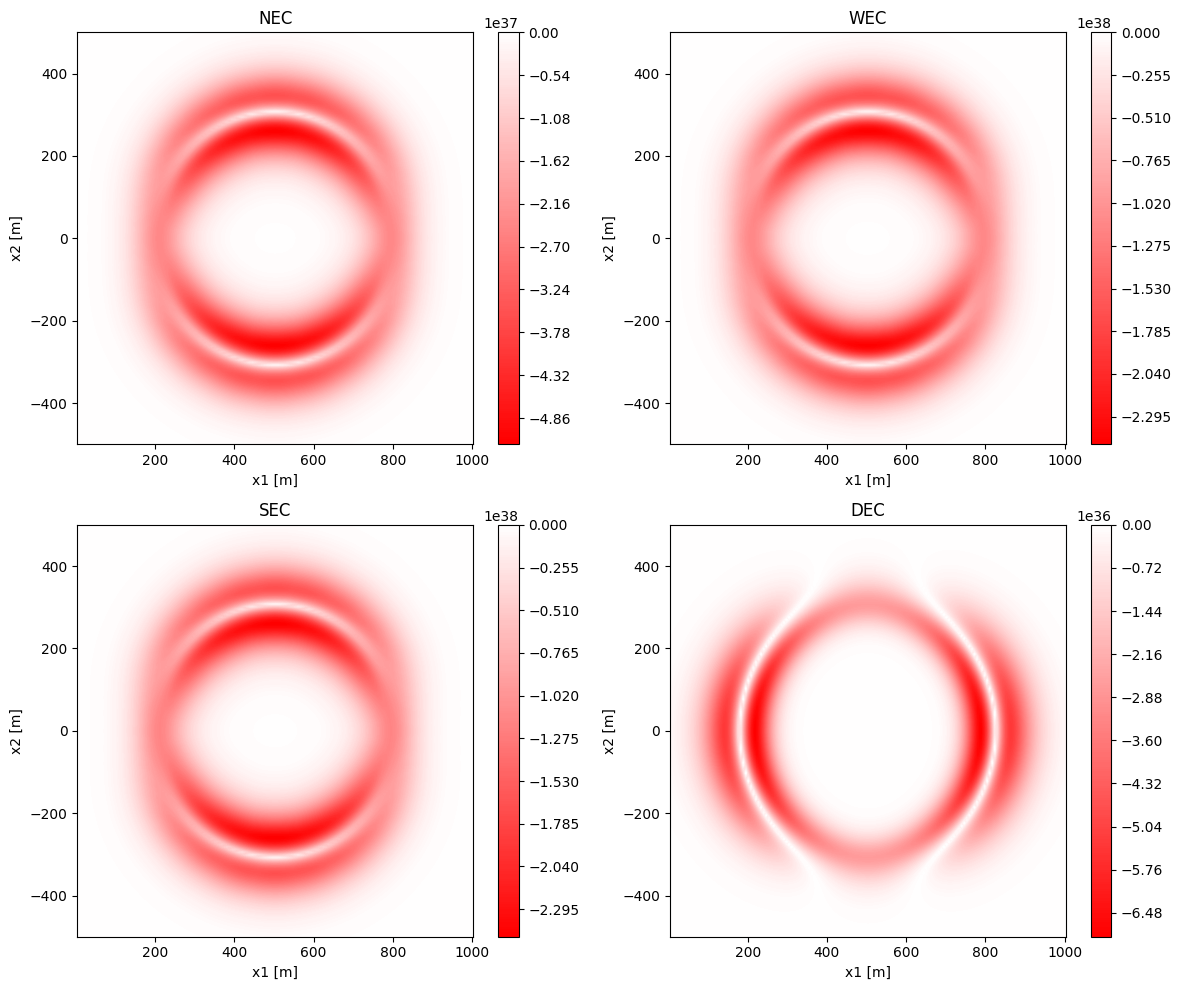

In [9]:
# Define the fixed values
t_val = 503/v_actual
z_val=0
# Create a grid for x and y
x_grid = np.linspace(-500, 500, 157) + 503.1  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 157)

warp_test.display_energy_conditions_2D(space_time_coordinate=[t_val,x_grid,y_grid,z_val],n_grid=10)

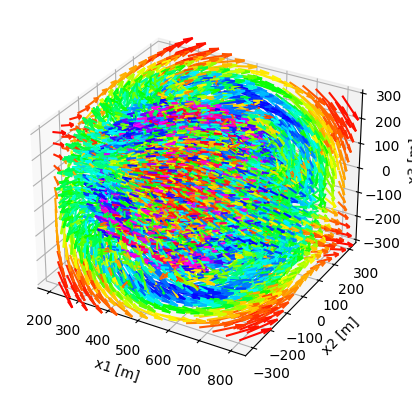

In [10]:
# Define the fixed values
t_val = 503/v_actual

# Create a grid for x and y
x_grid = np.linspace(-300, 300, 15) + 503.1  # Adjust the range and resolution as needed
y_grid = np.linspace(-300, 300, 15)
z_grid = np.linspace(-300, 300, 15)
warp_test.display_momentum_vector_field_3D(space_time_coordinate=[t_val,x_grid,y_grid,z_grid])

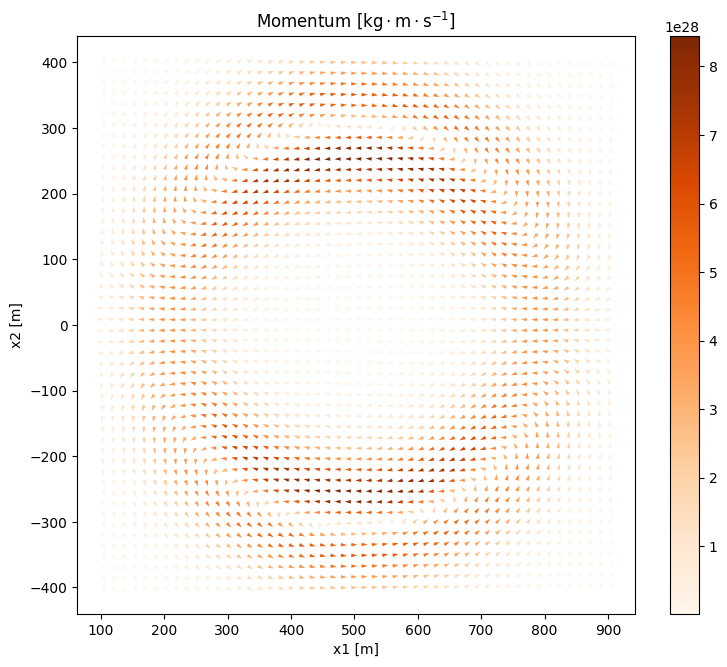

In [11]:
# Define the fixed values
t_val = 503/v_actual
z_val=0
# Create a grid for x and y
x_grid = np.linspace(-400, 400, 50) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-400, 400, 50)
warp_test.display_momentum_vector_field_2D(space_time_coordinate=[t_val,x_grid,y_grid,z_val])

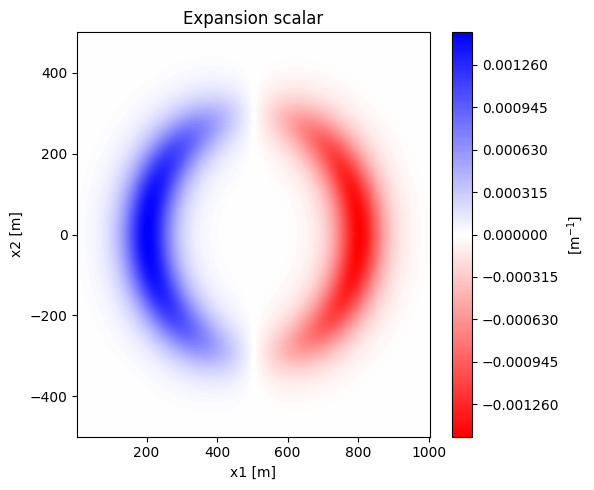

In [12]:
# Define the fixed values
t_val = 503/v_actual
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_metric_scalar(warp_test.expansion_scalar,space_time_coordinate=[t_val,x_grid,y_grid,z_val],title="Expansion scalar")

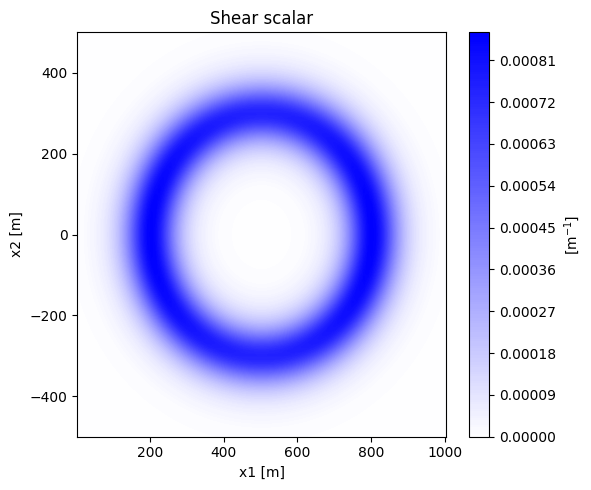

In [13]:
# Define the fixed values
t_val = 503/v_actual
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_metric_scalar(warp_test.shear_scalar,space_time_coordinate=[t_val,x_grid,y_grid,z_val],title="Shear scalar")

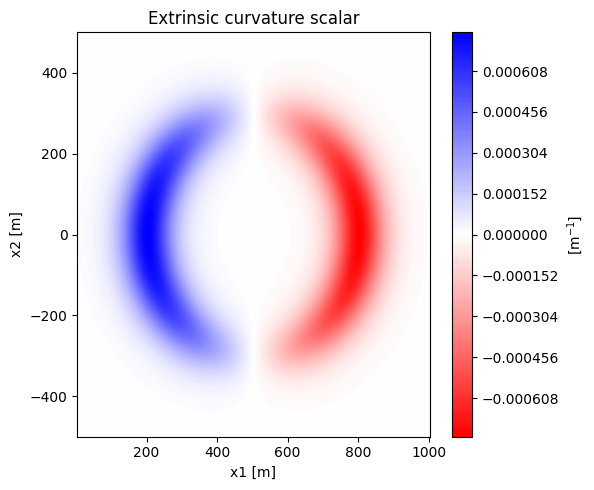

In [14]:
# Define the fixed values
t_val = 503/v_actual
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_metric_scalar(warp_test.K,space_time_coordinate=[t_val,x_grid,y_grid,z_val],title="Extrinsic curvature scalar")

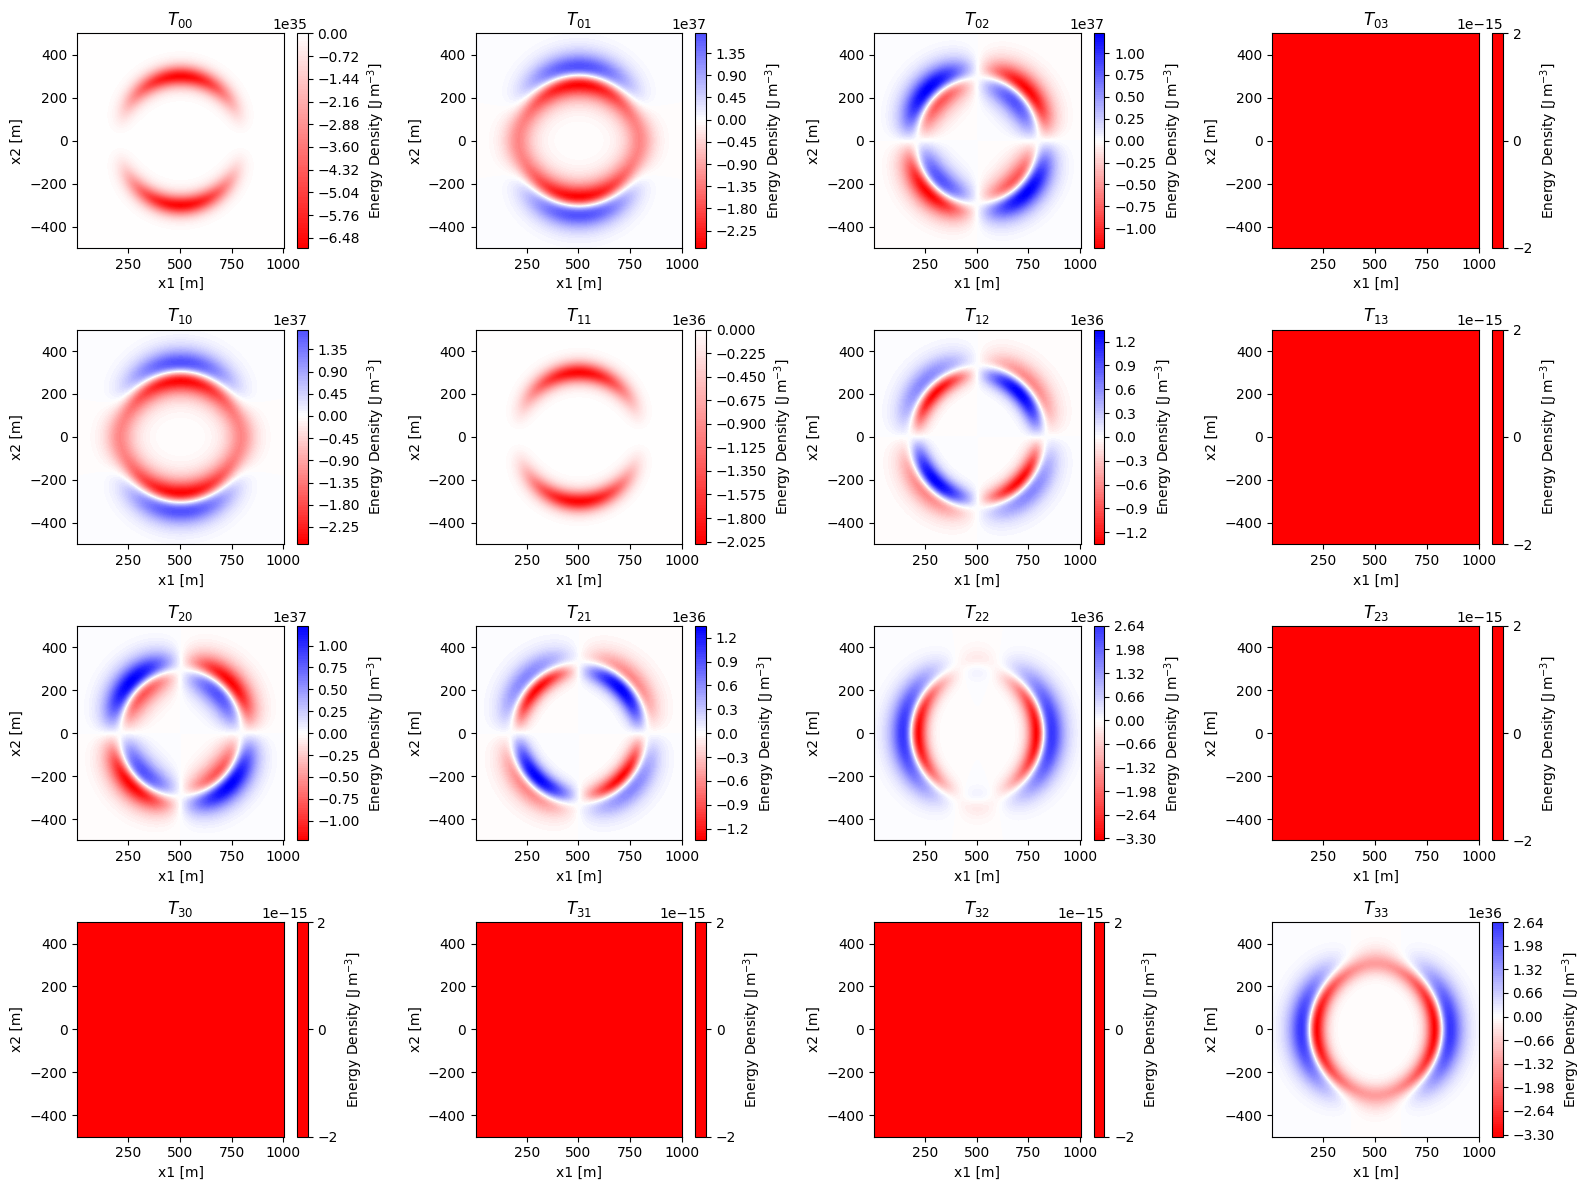

In [15]:
# Define the fixed values
t_val = 503/v_actual
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_energy_momentum_tensor_for_local_oberver(space_time_coordinate=[t_val,x_grid,y_grid,z_val])

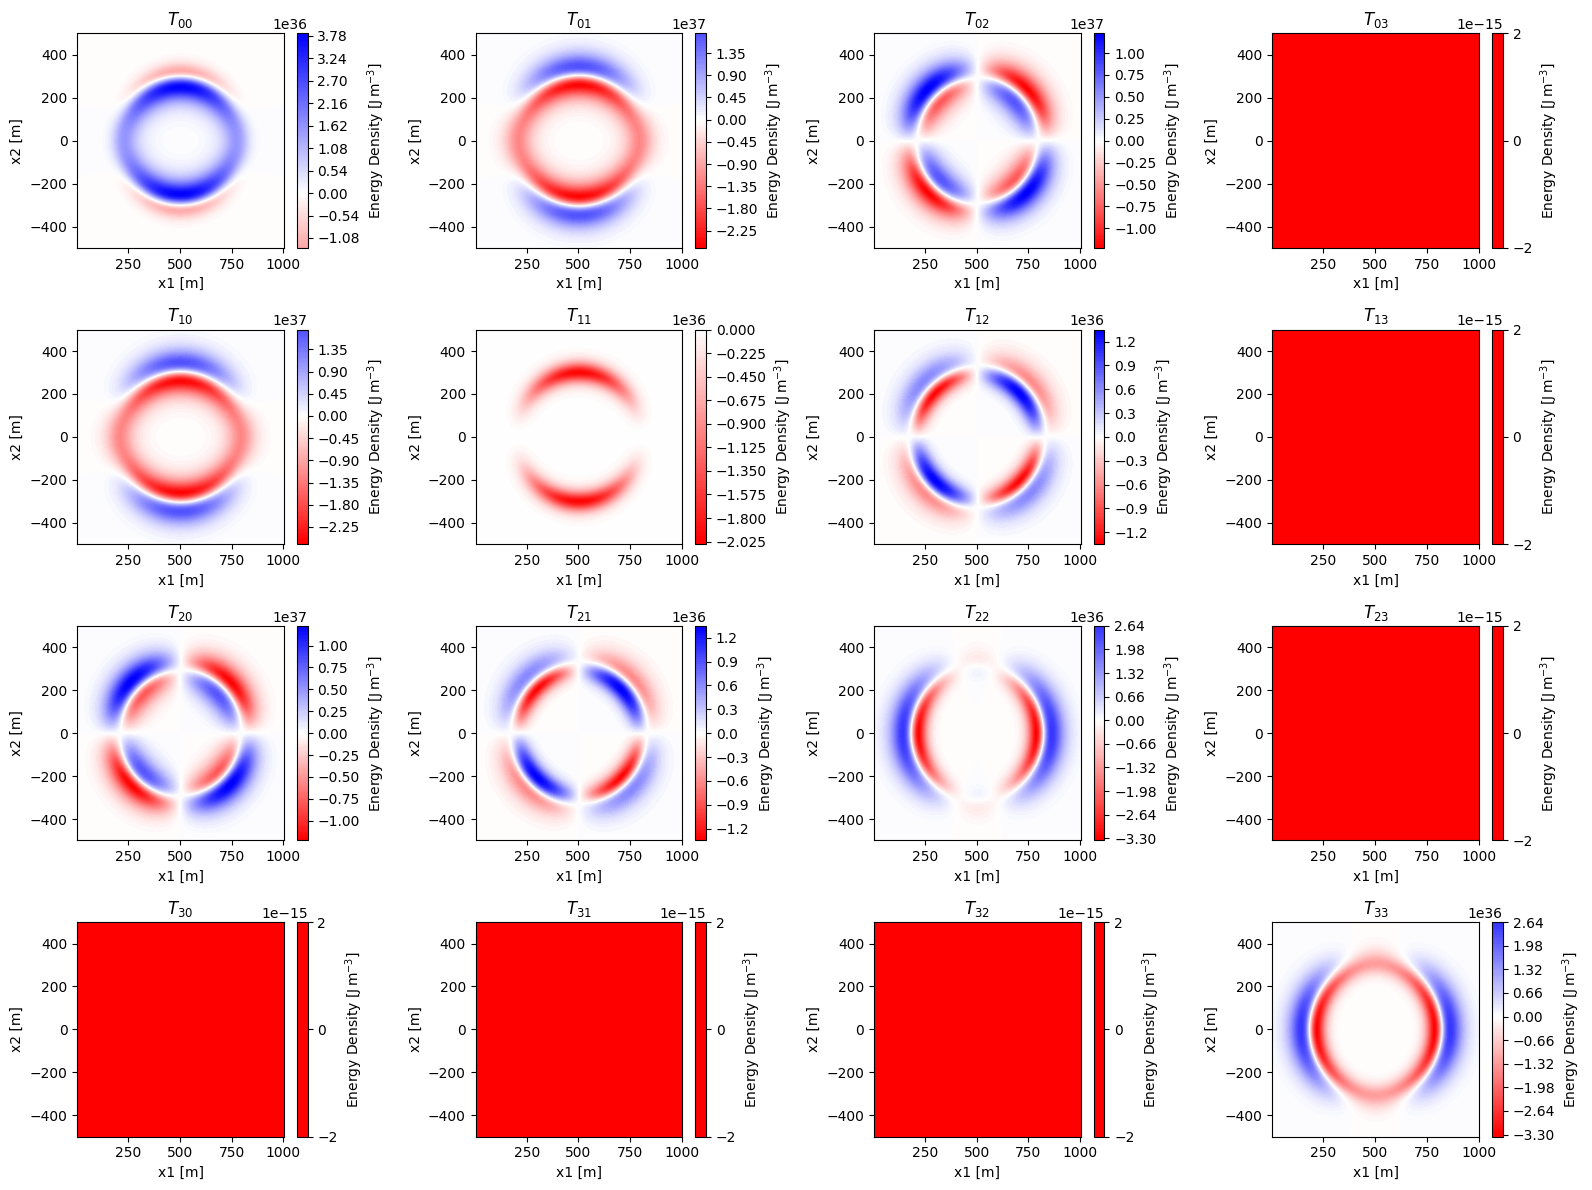

In [16]:
# Define the fixed values
t_val = 503/v_actual
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_energy_momentum_tensor_for_distant_oberver(space_time_coordinate=[t_val,x_grid,y_grid,z_val])

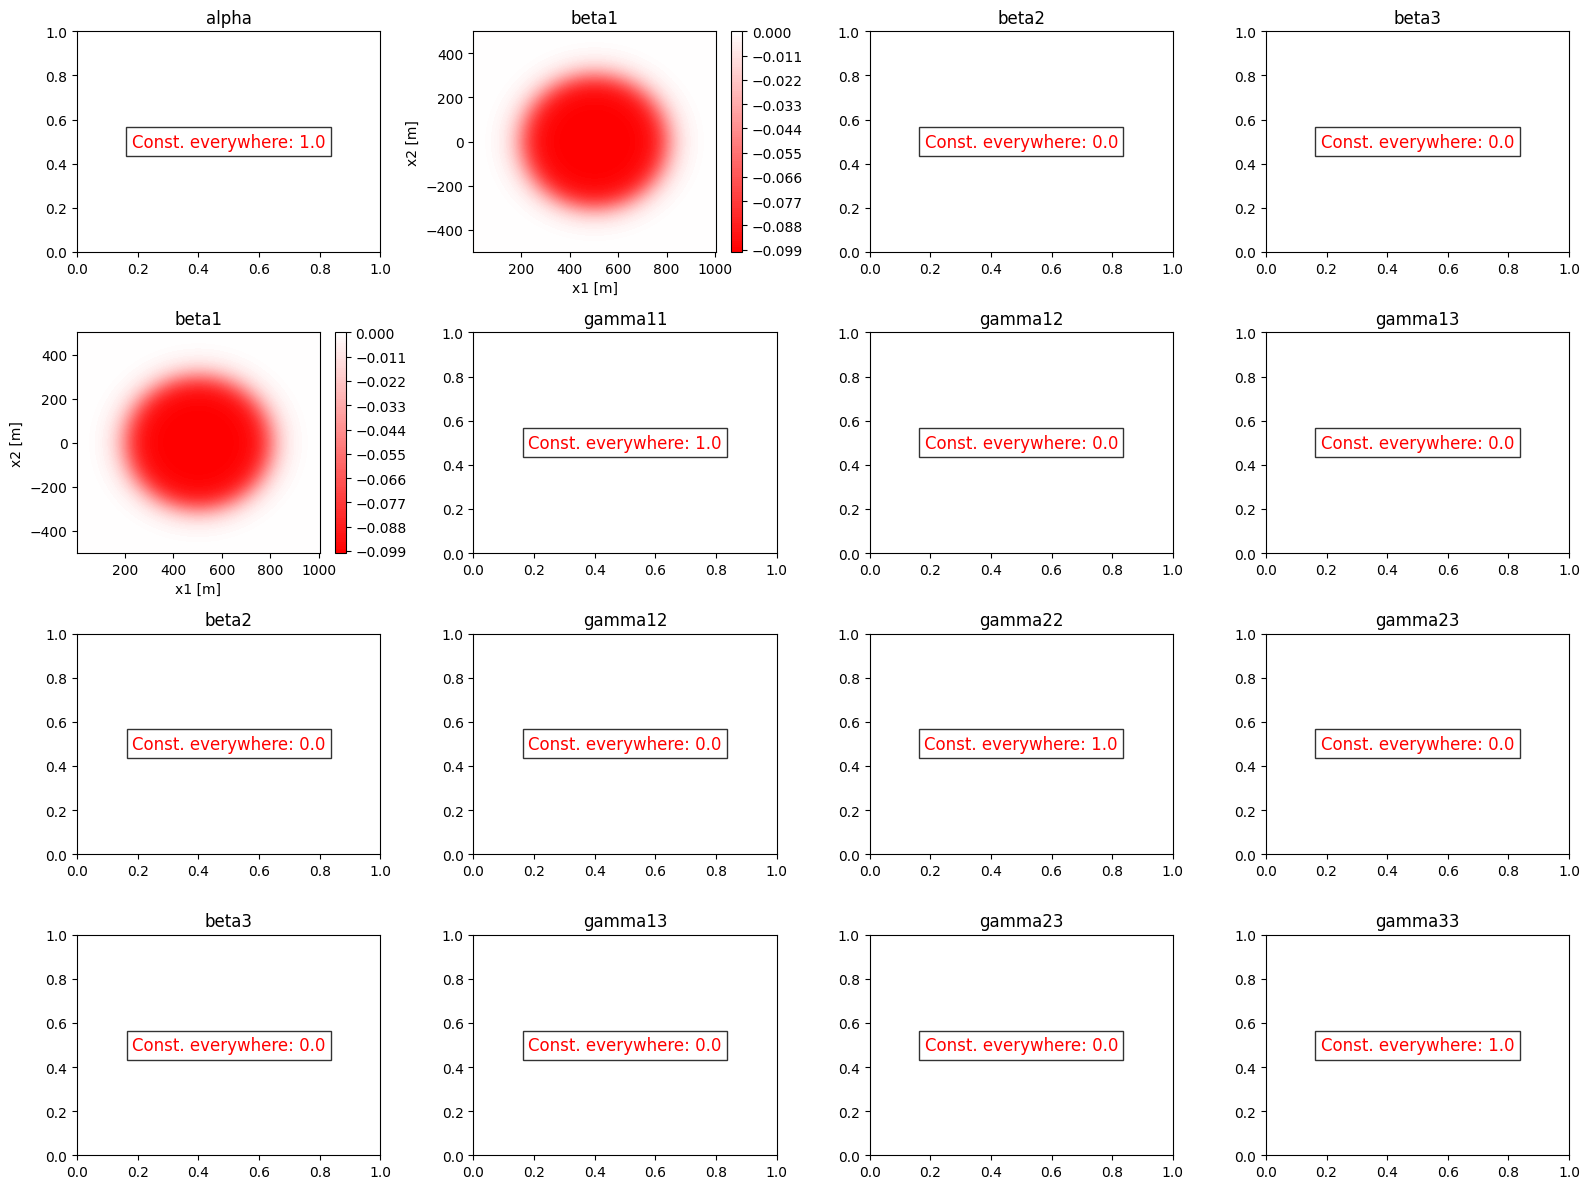

In [17]:
# Define the fixed values
t_val = 503/v_actual
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_31_metric(space_time_coordinate=[t_val,x_grid,y_grid,z_val])

### Van Den Broeck Metric

In [101]:
##################################################### USER INPUT ########################################################

# Define substitutions for the new variables

t,x,y,z = sp.symbols('t x y z')
symbols = [t,x,y,z] #IMPORTANT first symbol must be time

# Define the functions to be input in the metric
v = sp.Function('v')(t)
f = sp.Function('f', positive=True)(t, x, y, z)
B = sp.Function('B', positive=True)(t, x, y, z)



# Define the distance from the center of the warp bubble
rs = sp.sqrt((x - v*t)**2 + y**2 + z**2)


# Define the function f(rs)


# Define constants
alpha = 0.5
R = 350  # R = 350 m
R_tilde = 200  # R~ = 200 m
Delta = 40  # Δ = 40 m
Delta_tilde = 40  # Δ~ = 40 m

sigma=0.015/4

v_actual=0.1


if False: #Linear version 

    # Define f(rs) as a piecewise function with provided constants
    f_actual = sp.Piecewise(
        (1, rs < R),
        (1-(rs - R) / Delta, (rs >= R) & (rs < R + Delta)),
        (0, rs >= R + Delta)
    )
    
    # Define B(rs) as a piecewise function with provided constants
    B_actual= sp.Piecewise(
        (1 + alpha, rs < R_tilde),
        (1 + alpha - (alpha) * (rs - R_tilde) / Delta_tilde, (rs >= R_tilde) & (rs < R_tilde + Delta_tilde)),
        (1, rs >= R_tilde + Delta_tilde)
    )

if False: #flat constant with non-linear version piecwise
    # Define f(rs) as a piecewise function with provided constants
    f_actual = sp.Piecewise(
        (1, rs < R),
        (sp.cos(sp.pi*(R-rs)/(2*Delta)), (rs >= R) & (rs < R + Delta)),
        (0, rs >= R + Delta)
    )
    
    # Define B(rs) as a piecewise function with provided constants
    B_actual= sp.Piecewise(
        (1 + alpha, rs < R_tilde),
        (1 + alpha*sp.cos(sp.pi*(R_tilde-rs)/(2*Delta_tilde)), (rs >= R_tilde) & (rs < R_tilde + Delta_tilde)),
        (1, rs >= R_tilde + Delta_tilde)
    )

if True: #non-linear version
    sigma1=0.015*4
    sigma2=0.015*4
    f_actual = (sp.tanh(sigma1 * (rs + R)) - sp.tanh(sigma1 * (rs - R))) / (2 * sp.tanh(sigma1 * R))
    
    B_actual =1 + alpha*(sp.tanh(sigma2 * (rs + R_tilde)) - sp.tanh(sigma2 * (rs - R_tilde))) / (2 * sp.tanh(sigma2 * R_tilde))
    

f_subs={f:f_actual,v:v_actual,B:B_actual}

#user input metric using symbol
user_input_metric = {
    "g1": -1 + v**2*f**2*B**2,
    "g2": -v*f*B**2,
    "g3": 0,
    "g4": 0,
    "g5": B**2,
    "g6": 0,
    "g7": 0,
    "g8": B**2,
    "g9": 0,
    "g10": B**2  
}

##########################################################################################################################




warp_test=Warp_drive(symbols, f_subs, user_input_metric)
warp_test.build_and_compute()

Einstein tensor computed.
Tetrahed computed.
Metric scalar computed.
Extrinsic curvature computed.


In [102]:
warp_test.symbolic_display()

Metric :


Matrix([
[B(t, x, y, z)**2*f(t, x, y, z)**2*v(t)**2 - 1, -B(t, x, y, z)**2*f(t, x, y, z)*v(t),                0,                0],
[         -B(t, x, y, z)**2*f(t, x, y, z)*v(t),                     B(t, x, y, z)**2,                0,                0],
[                                            0,                                    0, B(t, x, y, z)**2,                0],
[                                            0,                                    0,                0, B(t, x, y, z)**2]])


T_uv for a distant observer :


Matrix([
[-0.75*B(t, x, y, z)**2*f(t, x, y, z)**2*v(t)**4*Derivative(f(t, x, y, z), y)**2 - 0.75*B(t, x, y, z)**2*f(t, x, y, z)**2*v(t)**4*Derivative(f(t, x, y, z), z)**2 - 2.0*B(t, x, y, z)*f(t, x, y, z)**4*v(t)**4*Derivative(B(t, x, y, z), (x, 2)) - 2.0*B(t, x, y, z)*f(t, x, y, z)**3*v(t)**4*Derivative(B(t, x, y, z), x)*Derivative(f(t, x, y, z), x) - 4.0*B(t, x, y, z)*f(t, x, y, z)**3*v(t)**3*Derivative(B(t, x, y, z), t, x) - 2.0*B(t, x, y, z)*f(t, x, y, z)**3*v(t)**2*Derivative(B(t, x, y, z), x)*Derivative(v(t), t) - 2.0*B(t, x, y, z)*f(t, x, y, z)**2*v(t)**3*Derivative(B(t, x, y, z), x)*Derivative(f(t, x, y, z), t) - 2.0*B(t, x, y, z)*f(t, x, y, z)**2*v(t)**2*Derivative(B(t, x, y, z), (t, 2)) - 1.0*f(t, x, y, z)**4*v(t)**4*Derivative(B(t, x, y, z), x)**2 - 2.0*f(t, x, y, z)**3*v(t)**3*Derivative(B(t, x, y, z), t)*Derivative(B(t, x, y, z), x) - 1.0*f(t, x, y, z)**2*v(t)**2*Derivative(B(t, x, y, z), t)**2 - 1.0*f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), (y, 2)) - 1.0*f(t, x, y, 


T_uv for a local observer :


Matrix([
[1.0*(-0.25*B(t, x, y, z)**4*v(t)**2*Derivative(f(t, x, y, z), y)**2 - 0.25*B(t, x, y, z)**4*v(t)**2*Derivative(f(t, x, y, z), z)**2 + 2.0*B(t, x, y, z)**3*f(t, x, y, z)*v(t)**2*Derivative(B(t, x, y, z), x)*Derivative(f(t, x, y, z), x) + 2.0*B(t, x, y, z)**3*v(t)*Derivative(B(t, x, y, z), t)*Derivative(f(t, x, y, z), x) + 3.0*B(t, x, y, z)**2*f(t, x, y, z)**2*v(t)**2*Derivative(B(t, x, y, z), x)**2 + 6.0*B(t, x, y, z)**2*f(t, x, y, z)*v(t)*Derivative(B(t, x, y, z), t)*Derivative(B(t, x, y, z), x) + 3.0*B(t, x, y, z)**2*Derivative(B(t, x, y, z), t)**2 - 2.0*B(t, x, y, z)*Derivative(B(t, x, y, z), (x, 2)) - 2.0*B(t, x, y, z)*Derivative(B(t, x, y, z), (y, 2)) - 2.0*B(t, x, y, z)*Derivative(B(t, x, y, z), (z, 2)) + 1.0*Derivative(B(t, x, y, z), x)**2 + 1.0*Derivative(B(t, x, y, z), y)**2 + 1.0*Derivative(B(t, x, y, z), z)**2)/B(t, x, y, z)**4,                                                                                                                                            

The 4-velocity vector of the observer is othogonal to the constant time hypersurfaces

Momentum :


Matrix([
[1.0*(0.5*B(t, x, y, z)**2*v(t)*Derivative(f(t, x, y, z), (y, 2)) + 0.5*B(t, x, y, z)**2*v(t)*Derivative(f(t, x, y, z), (z, 2)) - 2.0*B(t, x, y, z)*f(t, x, y, z)*v(t)*Derivative(B(t, x, y, z), (x, 2)) + 1.5*B(t, x, y, z)*v(t)*Derivative(B(t, x, y, z), y)*Derivative(f(t, x, y, z), y) + 1.5*B(t, x, y, z)*v(t)*Derivative(B(t, x, y, z), z)*Derivative(f(t, x, y, z), z) - 2.0*B(t, x, y, z)*Derivative(B(t, x, y, z), t, x) + 2.0*f(t, x, y, z)*v(t)*Derivative(B(t, x, y, z), x)**2 + 2.0*Derivative(B(t, x, y, z), t)*Derivative(B(t, x, y, z), x))/B(t, x, y, z)**3],
[                                                         (-B(t, x, y, z)**2*v(t)*Derivative(f(t, x, y, z), x, y) - 4*B(t, x, y, z)*f(t, x, y, z)*v(t)*Derivative(B(t, x, y, z), x, y) - B(t, x, y, z)*v(t)*Derivative(B(t, x, y, z), x)*Derivative(f(t, x, y, z), y) - 2*B(t, x, y, z)*v(t)*Derivative(B(t, x, y, z), y)*Derivative(f(t, x, y, z), x) - 4*B(t, x, y, z)*Derivative(B(t, x, y, z), t, y) + 4*f(t, x, y, z)*v(t)*Derivative(B(t,


expansion scalar :


2*(B(t, x, y, z)*v(t)*Derivative(f(t, x, y, z), x) + 3*f(t, x, y, z)*v(t)*Derivative(B(t, x, y, z), x) + 3*Derivative(B(t, x, y, z), t))/B(t, x, y, z)


shear scalar :


0.333333333333333*sqrt(3)*sqrt((4*Derivative(f(t, x, y, z), x)**2 + 3*Derivative(f(t, x, y, z), y)**2 + 3*Derivative(f(t, x, y, z), z)**2)*v(t)**2)


vorticity scalar :


0


alpha expression in 3+1 formalism :


1


beta_1 expression in 3+1 formalism :


-B(t, x, y, z)**2*f(t, x, y, z)*v(t)


beta_2 expression in 3+1 formalism :


0


beta_3 expression in 3+1 formalism :


0


space metric expression in 3+1 formalism :


Matrix([
[B(t, x, y, z)**2,                0,                0],
[               0, B(t, x, y, z)**2,                0],
[               0,                0, B(t, x, y, z)**2]])


Extrinsic curvature Kij :


Matrix([
[(-B(t, x, y, z)*v(t)*Derivative(f(t, x, y, z), x) - f(t, x, y, z)*v(t)*Derivative(B(t, x, y, z), x) - Derivative(B(t, x, y, z), t))*B(t, x, y, z),                                           -B(t, x, y, z)**2*v(t)*Derivative(f(t, x, y, z), y)/2,                                           -B(t, x, y, z)**2*v(t)*Derivative(f(t, x, y, z), z)/2],
[                                                                                            -B(t, x, y, z)**2*v(t)*Derivative(f(t, x, y, z), y)/2, (-f(t, x, y, z)*v(t)*Derivative(B(t, x, y, z), x) - Derivative(B(t, x, y, z), t))*B(t, x, y, z),                                                                                               0],
[                                                                                            -B(t, x, y, z)**2*v(t)*Derivative(f(t, x, y, z), z)/2,                                                                                               0, (-f(t, x, y, z)*v(t)*Derivative(B(t, x, y, z), x) - Derivati


Extrinsic curvature scalar :


(B(t, x, y, z)*v(t)*Derivative(f(t, x, y, z), x) + 3*f(t, x, y, z)*v(t)*Derivative(B(t, x, y, z), x) + 3*Derivative(B(t, x, y, z), t))/B(t, x, y, z)

(4, 4, 157, 157)


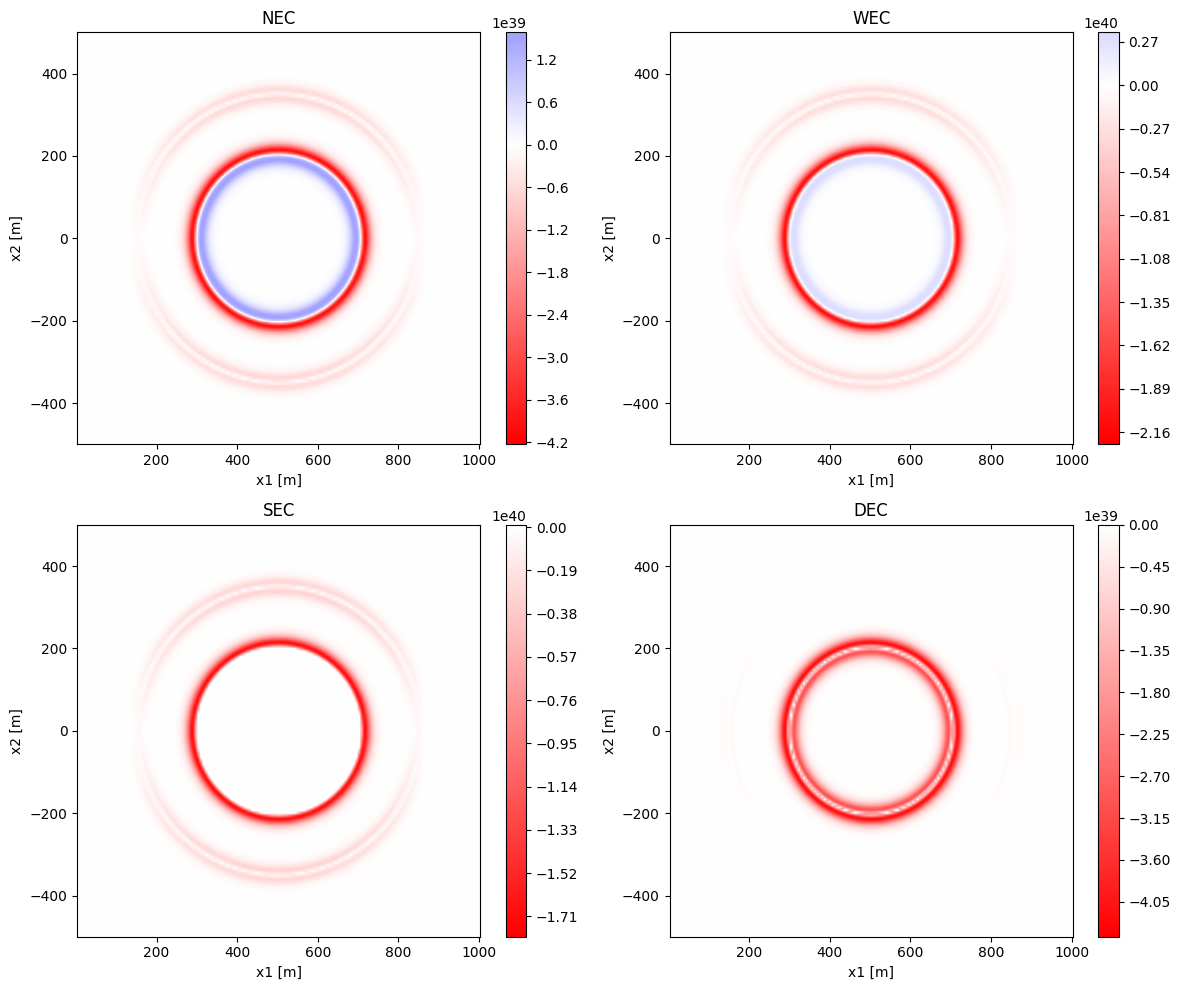

In [103]:
# Define the fixed values
t_val = 503/v_actual
z_val=0
# Create a grid for x and y
x_grid = np.linspace(-500, 500, 157) + 503.1  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 157)




warp_test.display_energy_conditions_2D(space_time_coordinate=[t_val,x_grid,y_grid,z_val],n_grid=10)

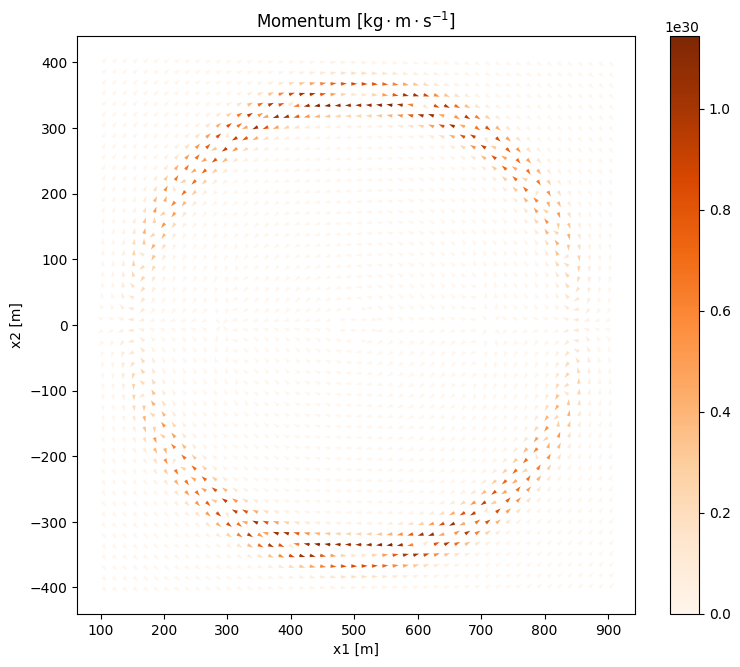

In [104]:
# Define the fixed values
t_val = 503/v_actual
z_val=0
# Create a grid for x and y
x_grid = np.linspace(-400, 400, 50) + 503.1  # Adjust the range and resolution as needed
y_grid = np.linspace(-400, 400, 50)
warp_test.display_momentum_vector_field_2D(space_time_coordinate=[t_val,x_grid,y_grid,z_val])

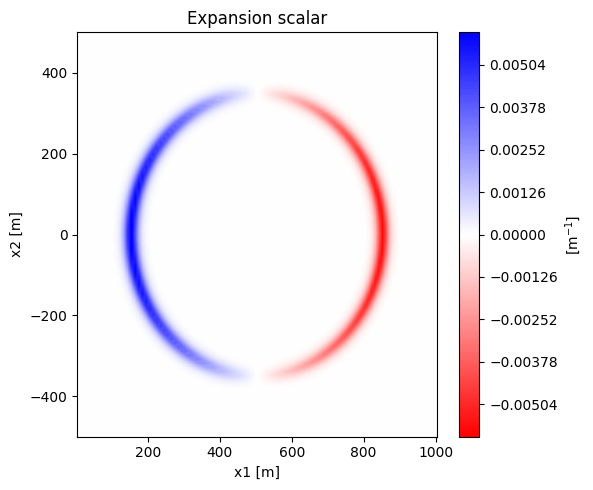

In [105]:
# Define the fixed values
t_val = 503/v_actual
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503.1  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_metric_scalar(warp_test.expansion_scalar,space_time_coordinate=[t_val,x_grid,y_grid,z_val],title="Expansion scalar")

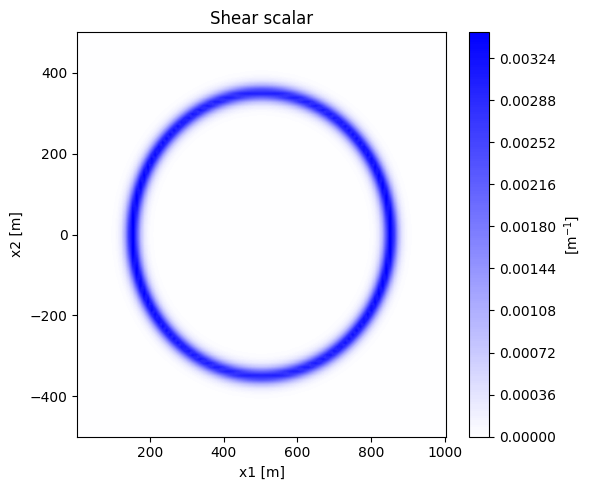

In [106]:
# Define the fixed values
t_val = 503/v_actual
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503.1  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_metric_scalar(warp_test.shear_scalar,space_time_coordinate=[t_val,x_grid,y_grid,z_val],title="Shear scalar")

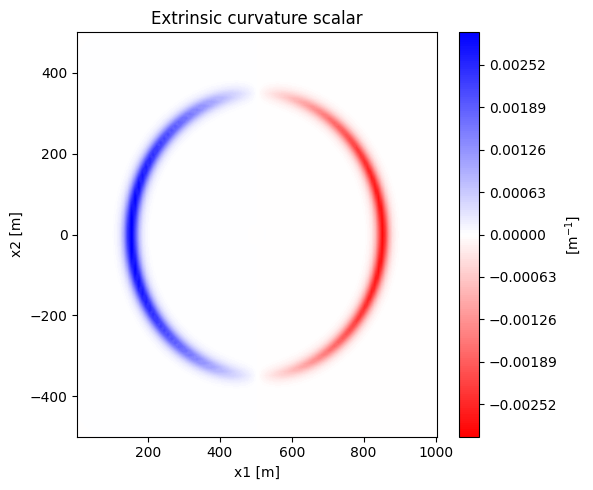

In [107]:
# Define the fixed values
t_val = 503/v_actual
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_metric_scalar(warp_test.K,space_time_coordinate=[t_val,x_grid,y_grid,z_val],title="Extrinsic curvature scalar")

Exposition of error in arXiv:2404.03095:

In their paper, the final figure presents an inner ring that does not appear in my results. I conducted a brief investigation.

In [108]:
warp_test.expansion_scalar

2*(B(t, x, y, z)*v(t)*Derivative(f(t, x, y, z), x) + 3*f(t, x, y, z)*v(t)*Derivative(B(t, x, y, z), x) + 3*Derivative(B(t, x, y, z), t))/B(t, x, y, z)

In [109]:
a1=2*3*sp.Derivative(B, t)/B
a2=2*3*sp.Derivative(B, x)/B*f*v
a3=2*sp.Derivative(f, x)*v


I replace f with 1, as I am specifically interested in the inner circle.
It’s important to note that f, when using the Alcubierre function that depends on hyperbolic tangents, is not exactly 1, leading to some differences.
However, the disparity presented in their paper is far too large to be accounted for by the non-linearity of f alone.

In [117]:
display(sp.simplify(a1.subs({f:1,B:B_actual,v:v_actual}).doit()))
display(sp.simplify(a2.subs({f:1,B:B_actual,v:v_actual}).doit()))

(0.000900000000067953*t - 0.00900000000067953*x)*(tanh(0.06*sqrt(y**2 + z**2 + (0.1*t - x)**2) - 12.0)**2 - tanh(0.06*sqrt(y**2 + z**2 + (0.1*t - x)**2) + 12.0)**2)/(sqrt(y**2 + z**2 + (0.1*t - x)**2)*(-0.250000000018876*tanh(0.06*sqrt(y**2 + z**2 + (0.1*t - x)**2) - 12.0) + 0.250000000018876*tanh(0.06*sqrt(y**2 + z**2 + (0.1*t - x)**2) + 12.0) + 1))

-(0.000900000000067953*t - 0.00900000000067953*x)*(tanh(0.06*sqrt(y**2 + z**2 + (0.1*t - x)**2) - 12.0)**2 - tanh(0.06*sqrt(y**2 + z**2 + (0.1*t - x)**2) + 12.0)**2)/(sqrt(y**2 + z**2 + (0.1*t - x)**2)*(-0.250000000018876*tanh(0.06*sqrt(y**2 + z**2 + (0.1*t - x)**2) - 12.0) + 0.250000000018876*tanh(0.06*sqrt(y**2 + z**2 + (0.1*t - x)**2) + 12.0) + 1))

In [120]:
#We check if both term are the same:
print(sp.simplify(a1.subs({f:1,B:B_actual,v:v_actual}).doit())==-sp.simplify(a2.subs({f:1,B:B_actual,v:v_actual}).doit()))

True


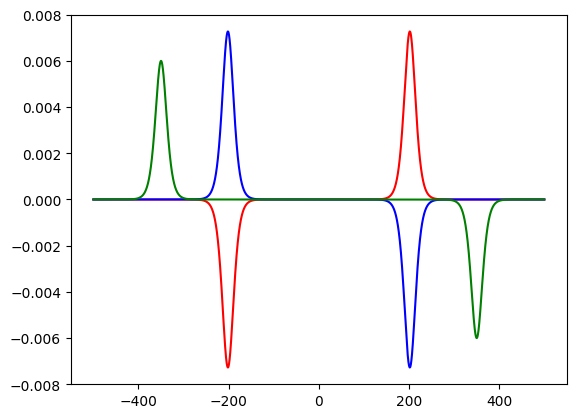

In [110]:
X_value=np.arange(-500,500,0.1)
plt.plot(X_value,sp.lambdify(tuple(warp_test.symbols), a1.subs(f_subs).doit(), 'numpy')(0,X_value,0,0),color="red")
plt.plot(X_value,sp.lambdify(tuple(warp_test.symbols), a2.subs(f_subs).doit(), 'numpy')(0,X_value,0,0),color="blue")
plt.plot(X_value,sp.lambdify(tuple(warp_test.symbols), a3.subs(f_subs).doit(), 'numpy')(0,X_value,0,0),color="green")
plt.show()

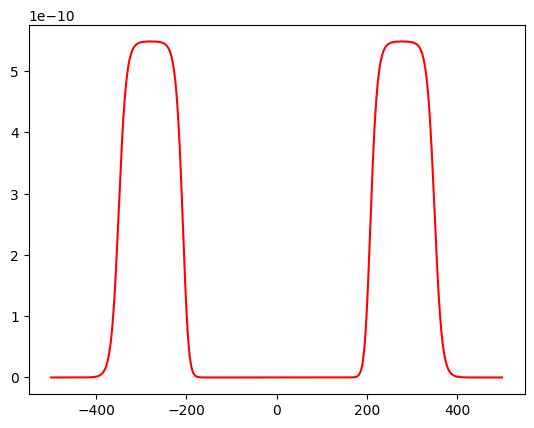

In [111]:
X_value=np.arange(-500,500,0.1)
delta=np.abs(sp.lambdify(tuple(warp_test.symbols), a1.subs(f_subs).doit(), 'numpy')(0,X_value,0,0)+sp.lambdify(tuple(warp_test.symbols), a2.subs(f_subs).doit(), 'numpy')(0,X_value,0,0))
plt.plot(X_value,delta,color="red")
plt.show()
#Here is the real difference when approximating f by 1

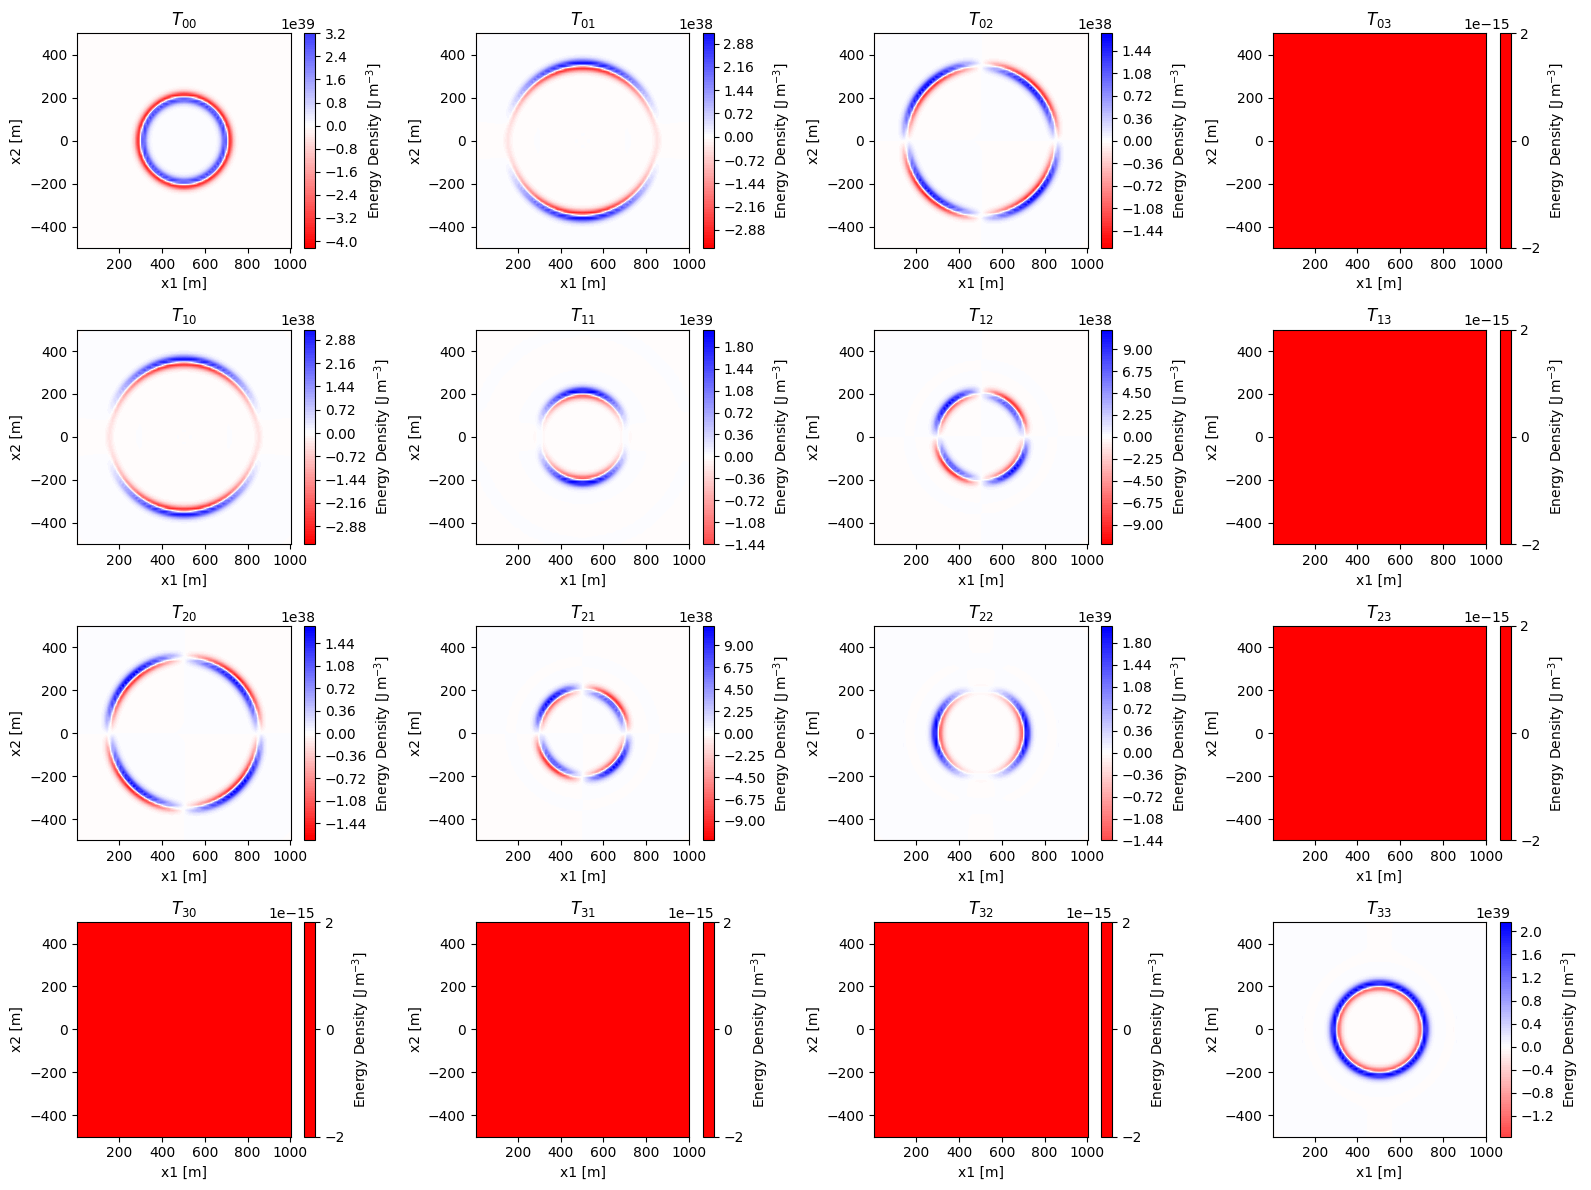

In [112]:
# Define the fixed values
t_val = 503/v_actual
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 80) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 80)

warp_test.display_energy_momentum_tensor_for_local_oberver(space_time_coordinate=[t_val,x_grid,y_grid,z_val])

Exposition of error in arXiv:2404.03095:



In [131]:
expr_error=warp_test.Tuv_ref[0,1].expand().subs({f:1}).doit() #terms that are not negligeable for the inner circle when approximating f by 1
display(expr_error)

-2.0*v(t)*Derivative(B(t, x, y, z), (x, 2))/B(t, x, y, z)**2 - 2.0*Derivative(B(t, x, y, z), t, x)/B(t, x, y, z)**2 + 2.0*v(t)*Derivative(B(t, x, y, z), x)**2/B(t, x, y, z)**3 + 2.0*Derivative(B(t, x, y, z), t)*Derivative(B(t, x, y, z), x)/B(t, x, y, z)**3

the terms cancel each others...

In [141]:
a1=sp.simplify(sp.Derivative(B, t).subs(f_subs).doit())
a2=sp.simplify((-v*sp.Derivative(B, x)).subs(f_subs).doit())

In [142]:
a1==a2

True

Once again, the approximation of f as 1 for the inner circle is insufficient to account for the energy differences displayed in arXiv:2404.03095. The error may potentially originate from the tetrahed. However, in tetrahed_test.ipynb, I tested both the tetrahed I used and the one they used for arbitrary metrics and found no issues. I believe the source of the errors lies either in numerical approximations or in the EinsteinPy library that I utilized. If the problem does stem from EinsteinPy, there is little I can do to address it.

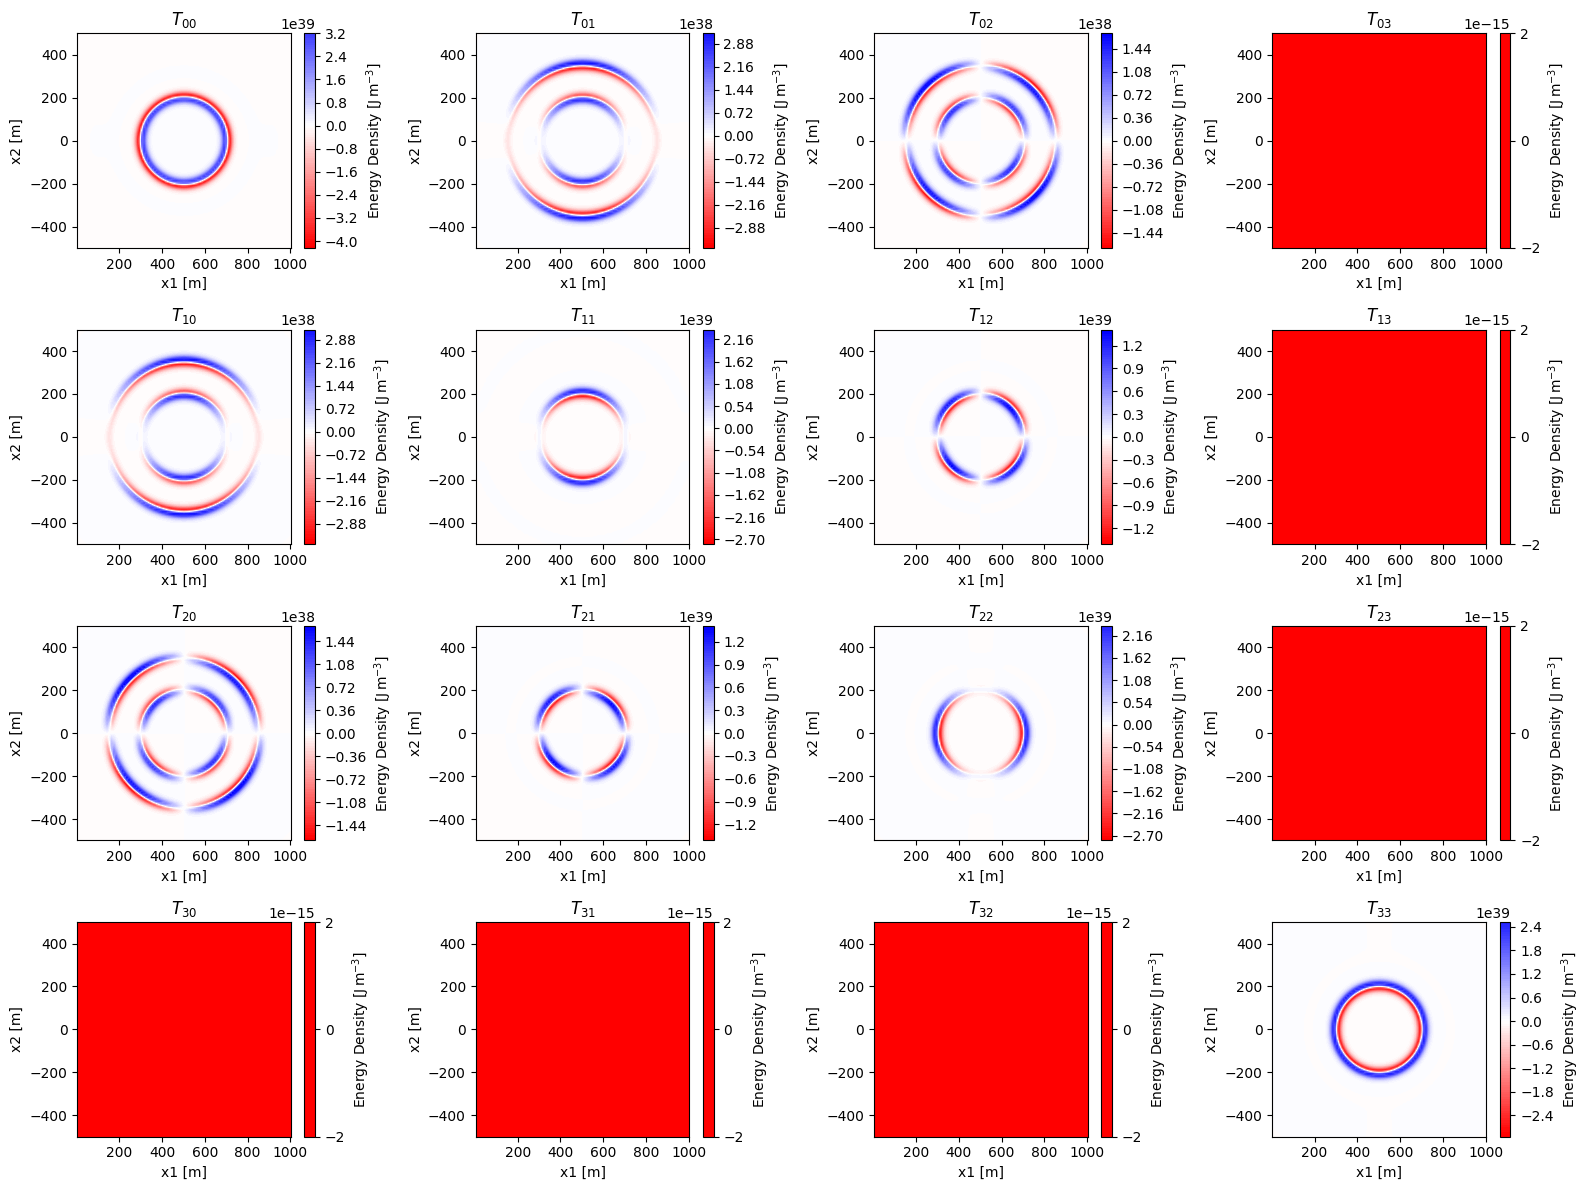

In [113]:
# Define the fixed values
t_val = 503/v_actual
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503.1  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)

warp_test.display_energy_momentum_tensor_for_distant_oberver(space_time_coordinate=[t_val,x_grid,y_grid,z_val])

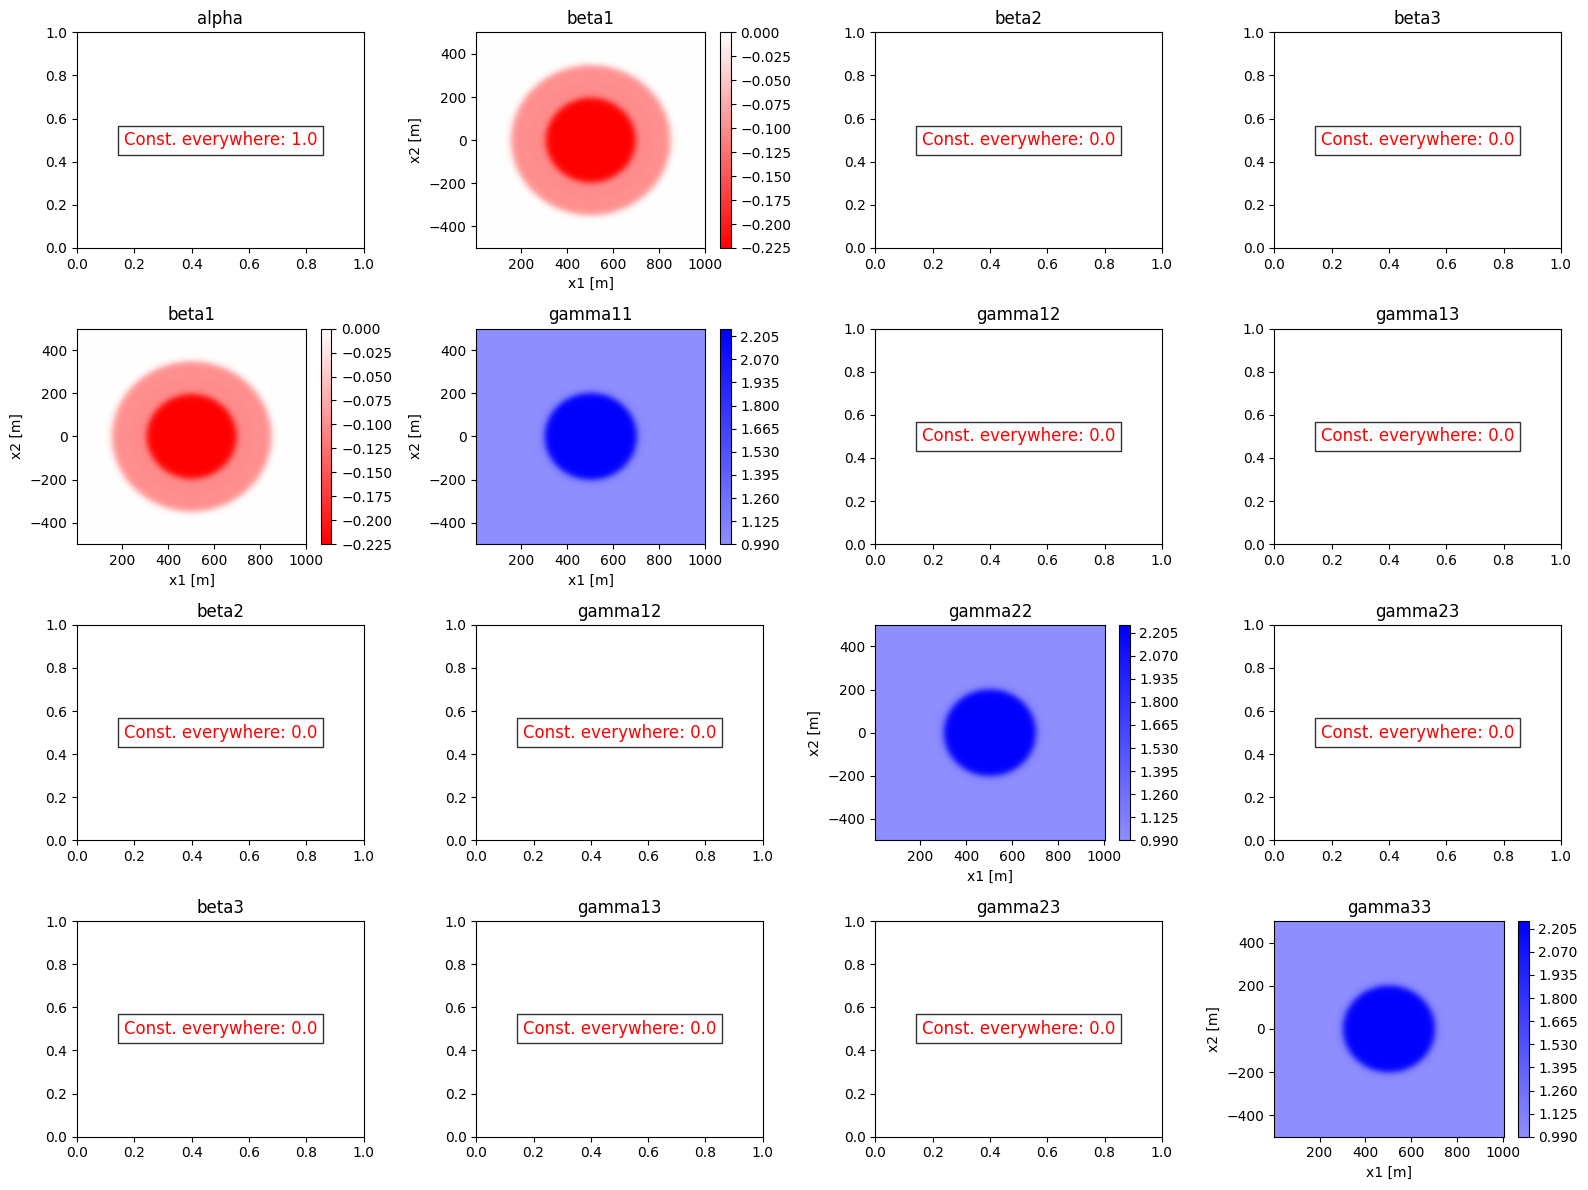

In [114]:
# Define the fixed values
t_val = 503/v_actual
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503.1  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_31_metric(space_time_coordinate=[t_val,x_grid,y_grid,z_val])

### Bobrick-Martire Modified Time Metric

In [ ]:
#need to mention A falsehood in their paper !!!!

In [ ]:
##################################################### USER INPUT ########################################################
#modified time

# Define substitutions for the new variables

t,x,y,z = sp.symbols('t x y z')
symbols = [t,x,y,z] #IMPORTANT first symbol must be time

# Define the functions to be input in the metric
v = sp.Function('v')(t)
f = sp.Function('f',real=True,positive=True)(t, x, y, z)

v_actual=0.1
R=300
sigma=0.015
A=2

# Define the distance from the center of the warp bubble
rs = sp.sqrt((x - v*t)**2 + y**2 + z**2)


# Define the function f(rs)
f_actual = (sp.tanh(sigma * (rs + R)) - sp.tanh(sigma * (rs - R))) / (2 * sp.tanh(sigma * R))

f_subs={f:f_actual,v:v_actual}

#user input metric using symbol
user_input_metric = {
    "g1": -((1-f)+f/A)**2+(f*v)**2,
    "g2": -v*f,
    "g3": 0,
    "g4": 0,
    "g5": 1,
    "g6": 0,
    "g7": 0,
    "g8": 1,
    "g9": 0,
    "g10": 1   
}

##########################################################################################################################




warp_test=Warp_drive(symbols, f_subs, user_input_metric)
warp_test.build_and_compute()

In [ ]:
# Define the fixed values
t_val = 503/v_actual
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503.1  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)

warp_test.display_energy_momentum_tensor_for_local_oberver(space_time_coordinate=[t_val,x_grid,y_grid,z_val])

In [ ]:
# Define the fixed values
t_val = 503/v_actual
z_val=0
# Create a grid for x and y
x_grid = np.linspace(-500, 500, 80) + 503.1  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 80)




warp_test.display_energy_conditions_2D(space_time_coordinate=[t_val,x_grid,y_grid,z_val],n_grid=10)

### Physical units

In [145]:
#   beta1,2,3 [unit = 1] 
#   gamma matrix [unit = 1] 
#   alpha [unit = 1] 

#   T^^  [unit = J m^-3] 

#expansion scalar [unit = m^-1] 

#shear scalar [unit = m^-1] 

#vorticity scalar [unit = m^-1] 

#K scalar [unit = m^-1] 

#Momentum flow  [unit = kg m s^-1 m^-3] 


#   NEC  [unit = J m^-3] #
#   WEC  [unit = J m^-3] #
#   SEC  [unit = J m^-3] #
#   DEC  [unit = J m^-3] #

#what I used:
#gravity_const=6.6743*1e-11
#c_speed_const=299792458
#pi_8=8*np.pi
#physical_energy_conversion=c_speed_const**4/pi_8/gravity_const
#physical_momentum_conversion=physical_energy_conversion/c_speed_const

#additional notes:
#   time must be given in distance (thus multiply by c).
#   R = 1/m^2
#   g=1
#   Tuv = c^4/8piG = J/m^3

### Sampling Test

In [ ]:
n_grid=100

# Define the sampling grid for theta and psi
theta_grid = np.linspace(0, 2 * np.pi, n_grid)
psi_grid = np.linspace(0, np.pi, n_grid)
s_grid=np.arange(0, 1, 1/n_grid)
s_grid=1-np.exp(-np.arange(0, n_grid))


# Create meshgrid to generate all pairs of (theta, psi)
theta_vals, psi_vals, s_vals = np.meshgrid(theta_grid, psi_grid, s_grid)

# Flatten the grid values to generate a list of theta and psi combinations
theta_vals_flat = theta_vals.flatten()
psi_vals_flat = psi_vals.flatten()
s_vals_flat =s_vals.flatten()

# Initialize a 4 x (n_grid * n_grid) matrix
ku_grid= np.zeros((4, n_grid**3))

# Fill the matrix with the computed values
ku_grid[0, :] = 1/np.sqrt(1-s_vals_flat**2)  # First row is all ones
ku_grid[1, :] = s_vals_flat*np.sin(theta_vals_flat) * np.cos(psi_vals_flat)/np.sqrt(1-s_vals_flat**2) 
ku_grid[2, :] = s_vals_flat*np.sin(theta_vals_flat) * np.sin(psi_vals_flat)/np.sqrt(1-s_vals_flat**2) 
ku_grid[3, :] = s_vals_flat*np.cos(theta_vals_flat)/np.sqrt(1-s_vals_flat**2) 

#print("ku")
#print(ku_grid.shape)

n_grid=10
# Define the sampling grid for eta_1, eta_2, eta_3
eta_limit=2
eta_1_grid = np.linspace(-eta_limit, eta_limit, n_grid)
eta_2_grid = np.linspace(-eta_limit, eta_limit, n_grid)
eta_3_grid = np.linspace(-eta_limit, eta_limit, n_grid)

# Create meshgrid to generate all combinations of (eta_1, eta_2, eta_3)
eta_1_vals, eta_2_vals, eta_3_vals = np.meshgrid(eta_1_grid, eta_2_grid, eta_3_grid)

# Flatten the grid values
eta_1_vals_flat = eta_1_vals.flatten()
eta_2_vals_flat = eta_2_vals.flatten()
eta_3_vals_flat = eta_3_vals.flatten()

# Initialize the 4 x (n_grid * n_grid * n_grid) matrix for Uu
Uu_grid = np.zeros((4, n_grid ** 3))

# Parametric time-vector
Uu_initial = np.array([1, 0, 0, 0])

# Iterate over all grid points
for i in range(n_grid ** 3):
    eta_1 = eta_1_vals_flat[i]
    eta_2 = eta_2_vals_flat[i]
    eta_3 = eta_3_vals_flat[i]
    
    # Compute the cosh and sinh for each eta
    cosh_1, sinh_1 = np.cosh(eta_1), np.sinh(eta_1)
    cosh_2, sinh_2 = np.cosh(eta_2), np.sinh(eta_2)
    cosh_3, sinh_3 = np.cosh(eta_3), np.sinh(eta_3)
    
    # Lorentz boost in the x-direction (eta_1)
    Lambda_1 = np.array([
        [cosh_1, -sinh_1, 0, 0],
        [-sinh_1, cosh_1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    
    # Lorentz boost in the y-direction (eta_2)
    Lambda_2 = np.array([
        [cosh_2, 0, -sinh_2, 0],
        [0, 1, 0, 0],
        [-sinh_2, 0, cosh_2, 0],
        [0, 0, 0, 1]
    ])
    
    # Lorentz boost in the z-direction (eta_3)
    Lambda_3 = np.array([
        [cosh_3, 0, 0, -sinh_3],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [-sinh_3, 0, 0, cosh_3]
    ])
    
    # Multiply the boosts in sequence and apply to the initial Uu vector
    Uu_result = Lambda_1 @ Lambda_2 @ Lambda_3 @ Uu_initial
    
    # Store the result in the Uu_matrix
    Uu_grid [:, i] = Uu_result



In [ ]:
# Create a 3D scatter plot
fig = plt.figure()
plt.scatter(Uu_grid[0, :], Uu_grid[1, :], c='b', marker='x') 
plt.scatter(ku_grid[0, :], ku_grid[1, :], c='r', marker='o')# You can customize the color and marker

# Show the plot
plt.xscale("log")
plt.show()